# ParkingWorld with Monte Carlo

In [1]:
import numpy as np
import pandas as pd
from agent import Agent
from environment import Environment
from rlglue import RLGlue
import time
from manager import Manager

In [2]:
class ParkingWorld(Environment):     
    def env_init(self, env_info={}):
        self.rand_generator = np.random.RandomState(env_info.get("seed"))
        
        reward = None
        observation = None
        is_terminal = None
        self.reward_obs_term = (reward, observation, is_terminal)
                
        self.num_spaces = env_info.get("num_spaces")
        self.num_prices = env_info.get("num_prices")

        self.states = [num_occupied for num_occupied in range(self.num_spaces)]
        self.actions = list(range(self.num_prices))
        
        self.manager = Manager()
        
        self.probabilities = self.manager.probabilities
        self.rewards = self.manager.rewards
               
    def env_start(self):
        reward = 0.
        
        self.current_state = np.random.randint(self.num_spaces)
        state = self.current_state
        
        is_terminal = False
        
        self.reward_obs_term = (reward, state, is_terminal)
        return self.reward_obs_term[1]
    
    def env_step(self, action):
        state = self.current_state

        self.current_state = self.rand_generator.choice(self.states, p=self.probabilities[action][state])

        reward = self.rewards[state][action]
        is_terminal = False
            
        if self.current_state==9:
            is_terminal = True
            
        self.reward_obs_term = (reward, self.current_state, is_terminal)

        return self.reward_obs_term

    def env_cleanup(self):
        self.current_state = None 

In [3]:
class MonteCarloEvaluation(Agent):
    def agent_init(self, agent_info={}):
        self.discount = agent_info.get("discount")
        self.policy = agent_info.get("policy")
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))
        self.v = np.zeros((self.policy.shape[0],))
        self.n = np.zeros((self.policy.shape[0],))
        
    def agent_start(self, state):
        action = self.agent_action(state)
        self.last_state = state

        self.episode_data = []

        return action

    def agent_step(self, reward, state):
        self.episode_data.append((self.last_state, reward))
        self.n[self.last_state] = self.n[self.last_state] + 1
        
        action = self.agent_action(state)
        self.last_state = state
        
        return action

    def agent_end(self, reward):
        self.episode_data.append((self.last_state, reward))
        self.n[self.last_state] = self.n[self.last_state] + 1
                
        target = 0
        for i in range(len(self.episode_data)-1, -1, -1):
            s,r = self.episode_data[i]
            target = r + self.discount*target 
            step_size = 1/self.n[s]
            self.v[s] = self.v[s] + step_size*(target-self.v[s])

    def agent_cleanup(self):
        self.last_state = None
                    
    def agent_action(self, state):
        return self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])

In [4]:
class PolicyEvaluation(RLGlue):
    def rl_run(self, env_info, agent_info, num_episodes, max_steps_this_episode, verbose=True):
        self.rl_init(agent_info, env_info)
        for episode in range(num_episodes):
            start_time = time.time()
            self.rl_episode(max_steps_this_episode) 
            now = time.time()
            duration = now - start_time
            if verbose:
                print('Episode: {}/{} - Steps: {}'.format(episode+1, num_episodes, self.num_steps))
                print('----- {}s -----'.format(np.round(1000*duration)/1000))
        self.rl_cleanup()
        return self.agent.v

-----

In [5]:
env_info = {"num_spaces": 1+10, 
            "num_prices": 4}

parking_world = ParkingWorld()

In [6]:
num_spaces = 1+10
num_prices = 4
                
city_policy = np.zeros((num_spaces, num_prices))
city_policy[:, 1] = 1
city_policy

agent_info = {"discount": 0.9,
              "policy": city_policy}

montecarlo_evaluation = MonteCarloEvaluation()

In [7]:
num_episodes = 10000
max_steps_this_episode = float('inf')

policy_evaluation = PolicyEvaluation(env=parking_world, agent=montecarlo_evaluation)
v = policy_evaluation.rl_run(env_info=env_info, 
                             agent_info=agent_info, 
                             num_episodes=num_episodes, 
                             max_steps_this_episode=max_steps_this_episode)

Episode: 1/10000 - Steps: 1
----- 0.0s -----
Episode: 2/10000 - Steps: 51
----- 0.002s -----
Episode: 3/10000 - Steps: 6
----- 0.0s -----
Episode: 4/10000 - Steps: 2
----- 0.0s -----
Episode: 5/10000 - Steps: 14
----- 0.0s -----
Episode: 6/10000 - Steps: 1
----- 0.0s -----
Episode: 7/10000 - Steps: 11
----- 0.0s -----
Episode: 8/10000 - Steps: 12
----- 0.0s -----
Episode: 9/10000 - Steps: 4
----- 0.0s -----
Episode: 10/10000 - Steps: 28
----- 0.001s -----
Episode: 11/10000 - Steps: 18
----- 0.0s -----
Episode: 12/10000 - Steps: 61
----- 0.001s -----
Episode: 13/10000 - Steps: 3
----- 0.0s -----
Episode: 14/10000 - Steps: 3
----- 0.0s -----
Episode: 15/10000 - Steps: 21
----- 0.001s -----
Episode: 16/10000 - Steps: 15
----- 0.0s -----
Episode: 17/10000 - Steps: 3
----- 0.0s -----
Episode: 18/10000 - Steps: 8
----- 0.0s -----
Episode: 19/10000 - Steps: 2
----- 0.0s -----
Episode: 20/10000 - Steps: 9
----- 0.0s -----
Episode: 21/10000 - Steps: 1
----- 0.0s -----
Episode: 22/10000 - Steps:

Episode: 567/10000 - Steps: 20
----- 0.0s -----
Episode: 568/10000 - Steps: 13
----- 0.0s -----
Episode: 569/10000 - Steps: 24
----- 0.0s -----
Episode: 570/10000 - Steps: 22
----- 0.0s -----
Episode: 571/10000 - Steps: 2
----- 0.0s -----
Episode: 572/10000 - Steps: 34
----- 0.001s -----
Episode: 573/10000 - Steps: 10
----- 0.0s -----
Episode: 574/10000 - Steps: 19
----- 0.0s -----
Episode: 575/10000 - Steps: 15
----- 0.0s -----
Episode: 576/10000 - Steps: 3
----- 0.0s -----
Episode: 577/10000 - Steps: 6
----- 0.0s -----
Episode: 578/10000 - Steps: 55
----- 0.001s -----
Episode: 579/10000 - Steps: 5
----- 0.0s -----
Episode: 580/10000 - Steps: 6
----- 0.0s -----
Episode: 581/10000 - Steps: 7
----- 0.0s -----
Episode: 582/10000 - Steps: 9
----- 0.0s -----
Episode: 583/10000 - Steps: 24
----- 0.0s -----
Episode: 584/10000 - Steps: 2
----- 0.0s -----
Episode: 585/10000 - Steps: 11
----- 0.0s -----
Episode: 586/10000 - Steps: 1
----- 0.0s -----
Episode: 587/10000 - Steps: 44
----- 0.001s -

Episode: 1009/10000 - Steps: 8
----- 0.0s -----
Episode: 1010/10000 - Steps: 1
----- 0.0s -----
Episode: 1011/10000 - Steps: 7
----- 0.0s -----
Episode: 1012/10000 - Steps: 16
----- 0.0s -----
Episode: 1013/10000 - Steps: 20
----- 0.0s -----
Episode: 1014/10000 - Steps: 8
----- 0.0s -----
Episode: 1015/10000 - Steps: 7
----- 0.0s -----
Episode: 1016/10000 - Steps: 6
----- 0.0s -----
Episode: 1017/10000 - Steps: 1
----- 0.0s -----
Episode: 1018/10000 - Steps: 5
----- 0.0s -----
Episode: 1019/10000 - Steps: 12
----- 0.0s -----
Episode: 1020/10000 - Steps: 7
----- 0.0s -----
Episode: 1021/10000 - Steps: 13
----- 0.0s -----
Episode: 1022/10000 - Steps: 11
----- 0.0s -----
Episode: 1023/10000 - Steps: 12
----- 0.0s -----
Episode: 1024/10000 - Steps: 11
----- 0.0s -----
Episode: 1025/10000 - Steps: 1
----- 0.0s -----
Episode: 1026/10000 - Steps: 3
----- 0.0s -----
Episode: 1027/10000 - Steps: 6
----- 0.0s -----
Episode: 1028/10000 - Steps: 4
----- 0.0s -----
Episode: 1029/10000 - Steps: 9
--

Episode: 1475/10000 - Steps: 2
----- 0.0s -----
Episode: 1476/10000 - Steps: 2
----- 0.0s -----
Episode: 1477/10000 - Steps: 13
----- 0.0s -----
Episode: 1478/10000 - Steps: 10
----- 0.0s -----
Episode: 1479/10000 - Steps: 2
----- 0.0s -----
Episode: 1480/10000 - Steps: 26
----- 0.001s -----
Episode: 1481/10000 - Steps: 7
----- 0.0s -----
Episode: 1482/10000 - Steps: 20
----- 0.0s -----
Episode: 1483/10000 - Steps: 12
----- 0.0s -----
Episode: 1484/10000 - Steps: 3
----- 0.0s -----
Episode: 1485/10000 - Steps: 13
----- 0.0s -----
Episode: 1486/10000 - Steps: 11
----- 0.0s -----
Episode: 1487/10000 - Steps: 7
----- 0.0s -----
Episode: 1488/10000 - Steps: 4
----- 0.0s -----
Episode: 1489/10000 - Steps: 1
----- 0.0s -----
Episode: 1490/10000 - Steps: 31
----- 0.001s -----
Episode: 1491/10000 - Steps: 18
----- 0.0s -----
Episode: 1492/10000 - Steps: 5
----- 0.0s -----
Episode: 1493/10000 - Steps: 5
----- 0.0s -----
Episode: 1494/10000 - Steps: 11
----- 0.0s -----
Episode: 1495/10000 - Step

Episode: 1975/10000 - Steps: 33
----- 0.001s -----
Episode: 1976/10000 - Steps: 47
----- 0.001s -----
Episode: 1977/10000 - Steps: 23
----- 0.001s -----
Episode: 1978/10000 - Steps: 4
----- 0.0s -----
Episode: 1979/10000 - Steps: 6
----- 0.0s -----
Episode: 1980/10000 - Steps: 5
----- 0.0s -----
Episode: 1981/10000 - Steps: 60
----- 0.001s -----
Episode: 1982/10000 - Steps: 16
----- 0.0s -----
Episode: 1983/10000 - Steps: 15
----- 0.0s -----
Episode: 1984/10000 - Steps: 10
----- 0.0s -----
Episode: 1985/10000 - Steps: 11
----- 0.0s -----
Episode: 1986/10000 - Steps: 25
----- 0.001s -----
Episode: 1987/10000 - Steps: 57
----- 0.001s -----
Episode: 1988/10000 - Steps: 6
----- 0.0s -----
Episode: 1989/10000 - Steps: 12
----- 0.0s -----
Episode: 1990/10000 - Steps: 29
----- 0.001s -----
Episode: 1991/10000 - Steps: 12
----- 0.0s -----
Episode: 1992/10000 - Steps: 11
----- 0.0s -----
Episode: 1993/10000 - Steps: 11
----- 0.0s -----
Episode: 1994/10000 - Steps: 11
----- 0.0s -----
Episode: 1

----- 0.0s -----
Episode: 2475/10000 - Steps: 8
----- 0.0s -----
Episode: 2476/10000 - Steps: 30
----- 0.001s -----
Episode: 2477/10000 - Steps: 76
----- 0.002s -----
Episode: 2478/10000 - Steps: 35
----- 0.001s -----
Episode: 2479/10000 - Steps: 55
----- 0.001s -----
Episode: 2480/10000 - Steps: 20
----- 0.0s -----
Episode: 2481/10000 - Steps: 6
----- 0.0s -----
Episode: 2482/10000 - Steps: 34
----- 0.001s -----
Episode: 2483/10000 - Steps: 1
----- 0.0s -----
Episode: 2484/10000 - Steps: 14
----- 0.0s -----
Episode: 2485/10000 - Steps: 1
----- 0.0s -----
Episode: 2486/10000 - Steps: 9
----- 0.0s -----
Episode: 2487/10000 - Steps: 5
----- 0.0s -----
Episode: 2488/10000 - Steps: 2
----- 0.0s -----
Episode: 2489/10000 - Steps: 6
----- 0.0s -----
Episode: 2490/10000 - Steps: 4
----- 0.0s -----
Episode: 2491/10000 - Steps: 3
----- 0.0s -----
Episode: 2492/10000 - Steps: 19
----- 0.0s -----
Episode: 2493/10000 - Steps: 28
----- 0.001s -----
Episode: 2494/10000 - Steps: 5
----- 0.0s -----
Ep

----- 0.0s -----
Episode: 2975/10000 - Steps: 3
----- 0.0s -----
Episode: 2976/10000 - Steps: 16
----- 0.0s -----
Episode: 2977/10000 - Steps: 7
----- 0.0s -----
Episode: 2978/10000 - Steps: 3
----- 0.0s -----
Episode: 2979/10000 - Steps: 3
----- 0.0s -----
Episode: 2980/10000 - Steps: 4
----- 0.0s -----
Episode: 2981/10000 - Steps: 3
----- 0.0s -----
Episode: 2982/10000 - Steps: 3
----- 0.0s -----
Episode: 2983/10000 - Steps: 1
----- 0.0s -----
Episode: 2984/10000 - Steps: 25
----- 0.001s -----
Episode: 2985/10000 - Steps: 12
----- 0.0s -----
Episode: 2986/10000 - Steps: 5
----- 0.0s -----
Episode: 2987/10000 - Steps: 22
----- 0.001s -----
Episode: 2988/10000 - Steps: 2
----- 0.0s -----
Episode: 2989/10000 - Steps: 4
----- 0.0s -----
Episode: 2990/10000 - Steps: 5
----- 0.0s -----
Episode: 2991/10000 - Steps: 5
----- 0.0s -----
Episode: 2992/10000 - Steps: 31
----- 0.001s -----
Episode: 2993/10000 - Steps: 2
----- 0.0s -----
Episode: 2994/10000 - Steps: 8
----- 0.0s -----
Episode: 299

Episode: 3474/10000 - Steps: 19
----- 0.0s -----
Episode: 3475/10000 - Steps: 9
----- 0.0s -----
Episode: 3476/10000 - Steps: 24
----- 0.001s -----
Episode: 3477/10000 - Steps: 5
----- 0.0s -----
Episode: 3478/10000 - Steps: 6
----- 0.0s -----
Episode: 3479/10000 - Steps: 12
----- 0.0s -----
Episode: 3480/10000 - Steps: 5
----- 0.0s -----
Episode: 3481/10000 - Steps: 9
----- 0.0s -----
Episode: 3482/10000 - Steps: 2
----- 0.0s -----
Episode: 3483/10000 - Steps: 30
----- 0.001s -----
Episode: 3484/10000 - Steps: 11
----- 0.0s -----
Episode: 3485/10000 - Steps: 6
----- 0.0s -----
Episode: 3486/10000 - Steps: 5
----- 0.0s -----
Episode: 3487/10000 - Steps: 41
----- 0.001s -----
Episode: 3488/10000 - Steps: 29
----- 0.001s -----
Episode: 3489/10000 - Steps: 23
----- 0.001s -----
Episode: 3490/10000 - Steps: 38
----- 0.001s -----
Episode: 3491/10000 - Steps: 9
----- 0.0s -----
Episode: 3492/10000 - Steps: 27
----- 0.001s -----
Episode: 3493/10000 - Steps: 34
----- 0.001s -----
Episode: 3494

Episode: 3973/10000 - Steps: 16
----- 0.0s -----
Episode: 3974/10000 - Steps: 4
----- 0.0s -----
Episode: 3975/10000 - Steps: 11
----- 0.0s -----
Episode: 3976/10000 - Steps: 2
----- 0.0s -----
Episode: 3977/10000 - Steps: 26
----- 0.001s -----
Episode: 3978/10000 - Steps: 17
----- 0.0s -----
Episode: 3979/10000 - Steps: 11
----- 0.0s -----
Episode: 3980/10000 - Steps: 6
----- 0.0s -----
Episode: 3981/10000 - Steps: 10
----- 0.0s -----
Episode: 3982/10000 - Steps: 2
----- 0.0s -----
Episode: 3983/10000 - Steps: 7
----- 0.0s -----
Episode: 3984/10000 - Steps: 2
----- 0.0s -----
Episode: 3985/10000 - Steps: 16
----- 0.0s -----
Episode: 3986/10000 - Steps: 5
----- 0.0s -----
Episode: 3987/10000 - Steps: 3
----- 0.0s -----
Episode: 3988/10000 - Steps: 3
----- 0.0s -----
Episode: 3989/10000 - Steps: 12
----- 0.0s -----
Episode: 3990/10000 - Steps: 15
----- 0.0s -----
Episode: 3991/10000 - Steps: 25
----- 0.001s -----
Episode: 3992/10000 - Steps: 21
----- 0.0s -----
Episode: 3993/10000 - Ste

Episode: 4438/10000 - Steps: 35
----- 0.001s -----
Episode: 4439/10000 - Steps: 54
----- 0.001s -----
Episode: 4440/10000 - Steps: 1
----- 0.0s -----
Episode: 4441/10000 - Steps: 12
----- 0.0s -----
Episode: 4442/10000 - Steps: 2
----- 0.0s -----
Episode: 4443/10000 - Steps: 35
----- 0.001s -----
Episode: 4444/10000 - Steps: 16
----- 0.0s -----
Episode: 4445/10000 - Steps: 64
----- 0.001s -----
Episode: 4446/10000 - Steps: 4
----- 0.0s -----
Episode: 4447/10000 - Steps: 21
----- 0.0s -----
Episode: 4448/10000 - Steps: 15
----- 0.0s -----
Episode: 4449/10000 - Steps: 13
----- 0.0s -----
Episode: 4450/10000 - Steps: 5
----- 0.0s -----
Episode: 4451/10000 - Steps: 8
----- 0.0s -----
Episode: 4452/10000 - Steps: 27
----- 0.001s -----
Episode: 4453/10000 - Steps: 13
----- 0.0s -----
Episode: 4454/10000 - Steps: 22
----- 0.0s -----
Episode: 4455/10000 - Steps: 30
----- 0.001s -----
Episode: 4456/10000 - Steps: 12
----- 0.0s -----
Episode: 4457/10000 - Steps: 8
----- 0.0s -----
Episode: 4458/

Episode: 4904/10000 - Steps: 6
----- 0.0s -----
Episode: 4905/10000 - Steps: 54
----- 0.001s -----
Episode: 4906/10000 - Steps: 2
----- 0.0s -----
Episode: 4907/10000 - Steps: 35
----- 0.001s -----
Episode: 4908/10000 - Steps: 7
----- 0.0s -----
Episode: 4909/10000 - Steps: 9
----- 0.0s -----
Episode: 4910/10000 - Steps: 3
----- 0.0s -----
Episode: 4911/10000 - Steps: 50
----- 0.001s -----
Episode: 4912/10000 - Steps: 19
----- 0.0s -----
Episode: 4913/10000 - Steps: 3
----- 0.0s -----
Episode: 4914/10000 - Steps: 5
----- 0.0s -----
Episode: 4915/10000 - Steps: 2
----- 0.0s -----
Episode: 4916/10000 - Steps: 2
----- 0.0s -----
Episode: 4917/10000 - Steps: 11
----- 0.0s -----
Episode: 4918/10000 - Steps: 22
----- 0.0s -----
Episode: 4919/10000 - Steps: 3
----- 0.0s -----
Episode: 4920/10000 - Steps: 7
----- 0.0s -----
Episode: 4921/10000 - Steps: 29
----- 0.001s -----
Episode: 4922/10000 - Steps: 25
----- 0.001s -----
Episode: 4923/10000 - Steps: 9
----- 0.0s -----
Episode: 4924/10000 - 

Episode: 5399/10000 - Steps: 6
----- 0.0s -----
Episode: 5400/10000 - Steps: 3
----- 0.0s -----
Episode: 5401/10000 - Steps: 5
----- 0.0s -----
Episode: 5402/10000 - Steps: 1
----- 0.0s -----
Episode: 5403/10000 - Steps: 1
----- 0.0s -----
Episode: 5404/10000 - Steps: 5
----- 0.0s -----
Episode: 5405/10000 - Steps: 2
----- 0.0s -----
Episode: 5406/10000 - Steps: 13
----- 0.0s -----
Episode: 5407/10000 - Steps: 10
----- 0.0s -----
Episode: 5408/10000 - Steps: 14
----- 0.0s -----
Episode: 5409/10000 - Steps: 1
----- 0.0s -----
Episode: 5410/10000 - Steps: 1
----- 0.0s -----
Episode: 5411/10000 - Steps: 4
----- 0.0s -----
Episode: 5412/10000 - Steps: 16
----- 0.0s -----
Episode: 5413/10000 - Steps: 5
----- 0.0s -----
Episode: 5414/10000 - Steps: 8
----- 0.0s -----
Episode: 5415/10000 - Steps: 19
----- 0.0s -----
Episode: 5416/10000 - Steps: 54
----- 0.001s -----
Episode: 5417/10000 - Steps: 24
----- 0.0s -----
Episode: 5418/10000 - Steps: 9
----- 0.0s -----
Episode: 5419/10000 - Steps: 20

Episode: 5894/10000 - Steps: 12
----- 0.0s -----
Episode: 5895/10000 - Steps: 11
----- 0.0s -----
Episode: 5896/10000 - Steps: 6
----- 0.0s -----
Episode: 5897/10000 - Steps: 3
----- 0.0s -----
Episode: 5898/10000 - Steps: 4
----- 0.0s -----
Episode: 5899/10000 - Steps: 12
----- 0.0s -----
Episode: 5900/10000 - Steps: 44
----- 0.001s -----
Episode: 5901/10000 - Steps: 18
----- 0.0s -----
Episode: 5902/10000 - Steps: 13
----- 0.0s -----
Episode: 5903/10000 - Steps: 60
----- 0.001s -----
Episode: 5904/10000 - Steps: 13
----- 0.0s -----
Episode: 5905/10000 - Steps: 3
----- 0.0s -----
Episode: 5906/10000 - Steps: 14
----- 0.0s -----
Episode: 5907/10000 - Steps: 24
----- 0.0s -----
Episode: 5908/10000 - Steps: 20
----- 0.0s -----
Episode: 5909/10000 - Steps: 5
----- 0.0s -----
Episode: 5910/10000 - Steps: 14
----- 0.0s -----
Episode: 5911/10000 - Steps: 21
----- 0.0s -----
Episode: 5912/10000 - Steps: 14
----- 0.0s -----
Episode: 5913/10000 - Steps: 13
----- 0.0s -----
Episode: 5914/10000 -

Episode: 6386/10000 - Steps: 60
----- 0.001s -----
Episode: 6387/10000 - Steps: 28
----- 0.001s -----
Episode: 6388/10000 - Steps: 31
----- 0.001s -----
Episode: 6389/10000 - Steps: 12
----- 0.0s -----
Episode: 6390/10000 - Steps: 4
----- 0.0s -----
Episode: 6391/10000 - Steps: 16
----- 0.0s -----
Episode: 6392/10000 - Steps: 18
----- 0.0s -----
Episode: 6393/10000 - Steps: 8
----- 0.0s -----
Episode: 6394/10000 - Steps: 17
----- 0.0s -----
Episode: 6395/10000 - Steps: 17
----- 0.0s -----
Episode: 6396/10000 - Steps: 2
----- 0.0s -----
Episode: 6397/10000 - Steps: 18
----- 0.0s -----
Episode: 6398/10000 - Steps: 2
----- 0.0s -----
Episode: 6399/10000 - Steps: 9
----- 0.0s -----
Episode: 6400/10000 - Steps: 13
----- 0.0s -----
Episode: 6401/10000 - Steps: 6
----- 0.0s -----
Episode: 6402/10000 - Steps: 4
----- 0.0s -----
Episode: 6403/10000 - Steps: 28
----- 0.001s -----
Episode: 6404/10000 - Steps: 14
----- 0.0s -----
Episode: 6405/10000 - Steps: 4
----- 0.0s -----
Episode: 6406/10000 

Episode: 6857/10000 - Steps: 11
----- 0.0s -----
Episode: 6858/10000 - Steps: 10
----- 0.0s -----
Episode: 6859/10000 - Steps: 5
----- 0.0s -----
Episode: 6860/10000 - Steps: 21
----- 0.0s -----
Episode: 6861/10000 - Steps: 2
----- 0.0s -----
Episode: 6862/10000 - Steps: 13
----- 0.0s -----
Episode: 6863/10000 - Steps: 2
----- 0.0s -----
Episode: 6864/10000 - Steps: 2
----- 0.0s -----
Episode: 6865/10000 - Steps: 12
----- 0.0s -----
Episode: 6866/10000 - Steps: 7
----- 0.0s -----
Episode: 6867/10000 - Steps: 1
----- 0.0s -----
Episode: 6868/10000 - Steps: 13
----- 0.0s -----
Episode: 6869/10000 - Steps: 3
----- 0.0s -----
Episode: 6870/10000 - Steps: 4
----- 0.0s -----
Episode: 6871/10000 - Steps: 3
----- 0.0s -----
Episode: 6872/10000 - Steps: 4
----- 0.0s -----
Episode: 6873/10000 - Steps: 7
----- 0.0s -----
Episode: 6874/10000 - Steps: 5
----- 0.0s -----
Episode: 6875/10000 - Steps: 2
----- 0.0s -----
Episode: 6876/10000 - Steps: 9
----- 0.0s -----
Episode: 6877/10000 - Steps: 1
---

Episode: 7330/10000 - Steps: 6
----- 0.001s -----
Episode: 7331/10000 - Steps: 1
----- 0.0s -----
Episode: 7332/10000 - Steps: 31
----- 0.001s -----
Episode: 7333/10000 - Steps: 13
----- 0.0s -----
Episode: 7334/10000 - Steps: 7
----- 0.0s -----
Episode: 7335/10000 - Steps: 7
----- 0.0s -----
Episode: 7336/10000 - Steps: 5
----- 0.0s -----
Episode: 7337/10000 - Steps: 10
----- 0.0s -----
Episode: 7338/10000 - Steps: 25
----- 0.001s -----
Episode: 7339/10000 - Steps: 16
----- 0.0s -----
Episode: 7340/10000 - Steps: 18
----- 0.0s -----
Episode: 7341/10000 - Steps: 7
----- 0.0s -----
Episode: 7342/10000 - Steps: 9
----- 0.0s -----
Episode: 7343/10000 - Steps: 23
----- 0.0s -----
Episode: 7344/10000 - Steps: 18
----- 0.0s -----
Episode: 7345/10000 - Steps: 4
----- 0.0s -----
Episode: 7346/10000 - Steps: 16
----- 0.0s -----
Episode: 7347/10000 - Steps: 43
----- 0.001s -----
Episode: 7348/10000 - Steps: 3
----- 0.0s -----
Episode: 7349/10000 - Steps: 27
----- 0.001s -----
Episode: 7350/10000

Episode: 7846/10000 - Steps: 21
----- 0.0s -----
Episode: 7847/10000 - Steps: 4
----- 0.0s -----
Episode: 7848/10000 - Steps: 15
----- 0.0s -----
Episode: 7849/10000 - Steps: 10
----- 0.0s -----
Episode: 7850/10000 - Steps: 3
----- 0.0s -----
Episode: 7851/10000 - Steps: 4
----- 0.0s -----
Episode: 7852/10000 - Steps: 7
----- 0.0s -----
Episode: 7853/10000 - Steps: 18
----- 0.0s -----
Episode: 7854/10000 - Steps: 6
----- 0.0s -----
Episode: 7855/10000 - Steps: 7
----- 0.0s -----
Episode: 7856/10000 - Steps: 5
----- 0.0s -----
Episode: 7857/10000 - Steps: 14
----- 0.0s -----
Episode: 7858/10000 - Steps: 26
----- 0.001s -----
Episode: 7859/10000 - Steps: 5
----- 0.0s -----
Episode: 7860/10000 - Steps: 1
----- 0.0s -----
Episode: 7861/10000 - Steps: 20
----- 0.0s -----
Episode: 7862/10000 - Steps: 37
----- 0.001s -----
Episode: 7863/10000 - Steps: 2
----- 0.0s -----
Episode: 7864/10000 - Steps: 95
----- 0.002s -----
Episode: 7865/10000 - Steps: 4
----- 0.0s -----
Episode: 7866/10000 - Ste

Episode: 8309/10000 - Steps: 42
----- 0.002s -----
Episode: 8310/10000 - Steps: 24
----- 0.0s -----
Episode: 8311/10000 - Steps: 6
----- 0.0s -----
Episode: 8312/10000 - Steps: 9
----- 0.0s -----
Episode: 8313/10000 - Steps: 5
----- 0.0s -----
Episode: 8314/10000 - Steps: 3
----- 0.0s -----
Episode: 8315/10000 - Steps: 8
----- 0.0s -----
Episode: 8316/10000 - Steps: 13
----- 0.0s -----
Episode: 8317/10000 - Steps: 6
----- 0.0s -----
Episode: 8318/10000 - Steps: 18
----- 0.0s -----
Episode: 8319/10000 - Steps: 11
----- 0.0s -----
Episode: 8320/10000 - Steps: 4
----- 0.0s -----
Episode: 8321/10000 - Steps: 43
----- 0.001s -----
Episode: 8322/10000 - Steps: 23
----- 0.0s -----
Episode: 8323/10000 - Steps: 12
----- 0.0s -----
Episode: 8324/10000 - Steps: 2
----- 0.0s -----
Episode: 8325/10000 - Steps: 2
----- 0.0s -----
Episode: 8326/10000 - Steps: 1
----- 0.0s -----
Episode: 8327/10000 - Steps: 8
----- 0.0s -----
Episode: 8328/10000 - Steps: 19
----- 0.0s -----
Episode: 8329/10000 - Steps

Episode: 8794/10000 - Steps: 12
----- 0.0s -----
Episode: 8795/10000 - Steps: 21
----- 0.0s -----
Episode: 8796/10000 - Steps: 4
----- 0.0s -----
Episode: 8797/10000 - Steps: 8
----- 0.0s -----
Episode: 8798/10000 - Steps: 30
----- 0.001s -----
Episode: 8799/10000 - Steps: 10
----- 0.0s -----
Episode: 8800/10000 - Steps: 1
----- 0.0s -----
Episode: 8801/10000 - Steps: 4
----- 0.0s -----
Episode: 8802/10000 - Steps: 5
----- 0.0s -----
Episode: 8803/10000 - Steps: 7
----- 0.0s -----
Episode: 8804/10000 - Steps: 24
----- 0.0s -----
Episode: 8805/10000 - Steps: 9
----- 0.0s -----
Episode: 8806/10000 - Steps: 7
----- 0.0s -----
Episode: 8807/10000 - Steps: 12
----- 0.0s -----
Episode: 8808/10000 - Steps: 17
----- 0.0s -----
Episode: 8809/10000 - Steps: 6
----- 0.0s -----
Episode: 8810/10000 - Steps: 11
----- 0.0s -----
Episode: 8811/10000 - Steps: 1
----- 0.0s -----
Episode: 8812/10000 - Steps: 1
----- 0.0s -----
Episode: 8813/10000 - Steps: 3
----- 0.0s -----
Episode: 8814/10000 - Steps: 2

Episode: 9318/10000 - Steps: 10
----- 0.0s -----
Episode: 9319/10000 - Steps: 5
----- 0.0s -----
Episode: 9320/10000 - Steps: 6
----- 0.0s -----
Episode: 9321/10000 - Steps: 14
----- 0.0s -----
Episode: 9322/10000 - Steps: 3
----- 0.0s -----
Episode: 9323/10000 - Steps: 3
----- 0.0s -----
Episode: 9324/10000 - Steps: 10
----- 0.0s -----
Episode: 9325/10000 - Steps: 12
----- 0.0s -----
Episode: 9326/10000 - Steps: 23
----- 0.0s -----
Episode: 9327/10000 - Steps: 2
----- 0.0s -----
Episode: 9328/10000 - Steps: 11
----- 0.0s -----
Episode: 9329/10000 - Steps: 2
----- 0.0s -----
Episode: 9330/10000 - Steps: 3
----- 0.0s -----
Episode: 9331/10000 - Steps: 13
----- 0.0s -----
Episode: 9332/10000 - Steps: 1
----- 0.0s -----
Episode: 9333/10000 - Steps: 11
----- 0.0s -----
Episode: 9334/10000 - Steps: 1
----- 0.0s -----
Episode: 9335/10000 - Steps: 23
----- 0.0s -----
Episode: 9336/10000 - Steps: 14
----- 0.0s -----
Episode: 9337/10000 - Steps: 4
----- 0.0s -----
Episode: 9338/10000 - Steps: 6

Episode: 9850/10000 - Steps: 19
----- 0.001s -----
Episode: 9851/10000 - Steps: 1
----- 0.0s -----
Episode: 9852/10000 - Steps: 1
----- 0.0s -----
Episode: 9853/10000 - Steps: 11
----- 0.0s -----
Episode: 9854/10000 - Steps: 25
----- 0.001s -----
Episode: 9855/10000 - Steps: 20
----- 0.0s -----
Episode: 9856/10000 - Steps: 5
----- 0.0s -----
Episode: 9857/10000 - Steps: 15
----- 0.0s -----
Episode: 9858/10000 - Steps: 14
----- 0.0s -----
Episode: 9859/10000 - Steps: 3
----- 0.0s -----
Episode: 9860/10000 - Steps: 12
----- 0.0s -----
Episode: 9861/10000 - Steps: 26
----- 0.001s -----
Episode: 9862/10000 - Steps: 19
----- 0.0s -----
Episode: 9863/10000 - Steps: 1
----- 0.0s -----
Episode: 9864/10000 - Steps: 6
----- 0.0s -----
Episode: 9865/10000 - Steps: 12
----- 0.0s -----
Episode: 9866/10000 - Steps: 4
----- 0.0s -----
Episode: 9867/10000 - Steps: 2
----- 0.0s -----
Episode: 9868/10000 - Steps: 13
----- 0.0s -----
Episode: 9869/10000 - Steps: 3
----- 0.0s -----
Episode: 9870/10000 - S

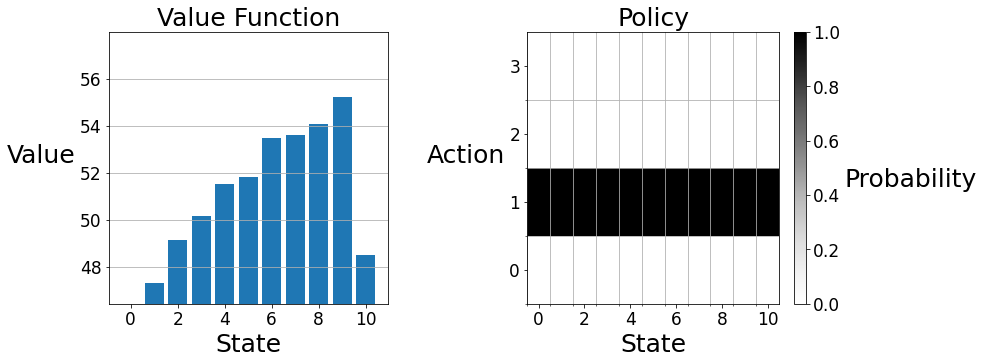

<Figure size 432x288 with 0 Axes>

In [8]:
parking_world.manager.plot(V=v, pi=city_policy)

-----

In [9]:
class MonteCarloControl(Agent):
    def agent_init(self, agent_info={}):
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))
        
        self.discount = agent_info.get("discount")
        self.num_actions = agent_info.get("num_actions")
        self.num_states = agent_info.get("num_states")
        self.epsilon = agent_info.get("epsilon")
        self.decay_factor = agent_info.get("decay_factor")
        
        self.q = np.zeros((self.num_states, self.num_actions)) 
        self.n = np.zeros((self.num_states, self.num_actions))
        
        self.policy = np.ones((self.num_states, self.num_actions))/self.num_actions
        
    def agent_start(self, state):
        action = self.agent_action(state)
        self.last_state = state
        self.last_action = action
        
        self.episode_data = []
        
        return action

    def agent_step(self, reward, state):
        self.episode_data.append((self.last_state, self.last_action, reward))
        self.n[self.last_state, self.last_action] = self.n[self.last_state, self.last_action] + 1
        
        action = self.agent_action(state)
        
        self.last_state = state
        self.last_action = action
        
        return action

    def agent_end(self, reward):
        self.episode_data.append((self.last_state, self.last_action, reward))
        self.n[self.last_state, self.last_action] = self.n[self.last_state, self.last_action] + 1
    
        
        target = 0
        for i in range(len(self.episode_data)-1, -1, -1):
            s,a,r = self.episode_data[i]
            
            target = r + self.discount*target 
            step_size = 1/self.n[s,a]
            self.q[s,a] = self.q[s,a] + step_size*(target-self.q[s,a])

            self.agent_improvement(s)
        
    def agent_cleanup(self):
        self.last_state = None
        self.last_action = None
            
    def agent_action(self, state):
        return self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
              
    def agent_improvement(self, state):
        self.epsilon = self.decay_factor*self.epsilon

        idx = self.agent_argmax(state)
        
        self.policy[state,:] = 0.
        self.policy[state,idx] = 1.
        p1 = self.epsilon/self.num_actions
        p2 = 1-(self.num_actions-1)*p1
        self.policy[state] = p1*(np.ones(self.num_actions)-self.policy[state]) + p2*self.policy[state]
                
    def agent_argmax(self, state):
        q_max = np.max(self.q[state,:])
        y = 1-np.square(np.sign(self.q[state,:]-q_max))
        y = y/np.sum(y)
        return self.rand_generator.choice(self.num_actions, p=y)

In [10]:
class PolicyIteration(RLGlue):
    def rl_run(self, env_info, agent_info, num_episodes, max_steps_this_episode, verbose=True):
        self.rl_init(agent_info, env_info)        
        for episode in range(num_episodes):
            start_time = time.time()
            self.rl_episode(max_steps_this_episode) 
            now = time.time()
            duration = now - start_time
            if verbose:
                print('Episode: {}/{} - Steps: {} - Epsilon: {}'.format(episode+1, num_episodes, self.num_steps, self.agent.epsilon))
                print('----- {}s -----'.format(np.round(1000*duration)/1000))

        self.rl_cleanup()
        return self.agent.policy

-----

In [11]:
agent_info = {"discount": 0.9, 
              "num_states": 1+10, 
              "num_actions": 4, 
              "epsilon": 0.9,
              "decay_factor": 0.99997}

montecarlo_control = MonteCarloControl()

In [12]:
num_episodes = 10000
max_steps_this_episode = float('inf')

policy_iteration = PolicyIteration(env=parking_world, agent=montecarlo_control)
optimal_policy = policy_iteration.rl_run(env_info=env_info, 
                                         agent_info=agent_info, 
                                         num_episodes=num_episodes, 
                                         max_steps_this_episode=max_steps_this_episode)

Episode: 1/10000 - Steps: 44 - Epsilon: 0.8988127659382708
----- 0.003s -----
Episode: 2/10000 - Steps: 32 - Epsilon: 0.8979503067926466
----- 0.002s -----
Episode: 3/10000 - Steps: 11 - Epsilon: 0.8976540276359454
----- 0.001s -----
Episode: 4/10000 - Steps: 11 - Epsilon: 0.8973578462367013
----- 0.001s -----
Episode: 5/10000 - Steps: 42 - Epsilon: 0.8962278704349751
----- 0.002s -----
Episode: 6/10000 - Steps: 13 - Epsilon: 0.8958784044737821
----- 0.001s -----
Episode: 7/10000 - Steps: 16 - Epsilon: 0.8954484795809584
----- 0.001s -----
Episode: 8/10000 - Steps: 32 - Epsilon: 0.8945892486488702
----- 0.002s -----
Episode: 9/10000 - Steps: 7 - Epsilon: 0.8944014018135455
----- 0.0s -----
Episode: 10/10000 - Steps: 1 - Epsilon: 0.8943745697714912
----- 0.0s -----
Episode: 11/10000 - Steps: 1 - Epsilon: 0.8943477385343981
----- 0.0s -----
Episode: 12/10000 - Steps: 11 - Epsilon: 0.8940526480469109
----- 0.001s -----
Episode: 13/10000 - Steps: 6 - Epsilon: 0.8938917306394906
----- 0.0s 

Episode: 310/10000 - Steps: 58 - Epsilon: 0.7848579216975269
----- 0.002s -----
Episode: 311/10000 - Steps: 15 - Epsilon: 0.7845048097921956
----- 0.001s -----
Episode: 312/10000 - Steps: 6 - Epsilon: 0.7843636095168244
----- 0.0s -----
Episode: 313/10000 - Steps: 4 - Epsilon: 0.7842694901191614
----- 0.0s -----
Episode: 314/10000 - Steps: 29 - Epsilon: 0.7835874621574709
----- 0.001s -----
Episode: 315/10000 - Steps: 4 - Epsilon: 0.7834934358932998
----- 0.0s -----
Episode: 316/10000 - Steps: 14 - Epsilon: 0.7831644328106376
----- 0.001s -----
Episode: 317/10000 - Steps: 11 - Epsilon: 0.782906027310961
----- 0.0s -----
Episode: 318/10000 - Steps: 39 - Epsilon: 0.7819905491859055
----- 0.002s -----
Episode: 319/10000 - Steps: 6 - Epsilon: 0.7818498014435022
----- 0.0s -----
Episode: 320/10000 - Steps: 44 - Epsilon: 0.7808184250930245
----- 0.002s -----
Episode: 321/10000 - Steps: 2 - Epsilon: 0.7807715766902555
----- 0.0s -----
Episode: 322/10000 - Steps: 10 - Epsilon: 0.78053737683596

Episode: 622/10000 - Steps: 65 - Epsilon: 0.6909661245398803
----- 0.003s -----
Episode: 623/10000 - Steps: 24 - Epsilon: 0.6904688005284434
----- 0.001s -----
Episode: 624/10000 - Steps: 5 - Epsilon: 0.690365236422397
----- 0.0s -----
Episode: 625/10000 - Steps: 12 - Epsilon: 0.6901167459408798
----- 0.0s -----
Episode: 626/10000 - Steps: 14 - Epsilon: 0.6898269534213645
----- 0.001s -----
Episode: 627/10000 - Steps: 9 - Epsilon: 0.6896407224927698
----- 0.0s -----
Episode: 628/10000 - Steps: 18 - Epsilon: 0.6892684114509592
----- 0.001s -----
Episode: 629/10000 - Steps: 1 - Epsilon: 0.6892477333986157
----- 0.0s -----
Episode: 630/10000 - Steps: 7 - Epsilon: 0.689103004400733
----- 0.0s -----
Episode: 631/10000 - Steps: 4 - Epsilon: 0.6890203157612869
----- 0.0s -----
Episode: 632/10000 - Steps: 7 - Epsilon: 0.68887563451681
----- 0.0s -----
Episode: 633/10000 - Steps: 6 - Epsilon: 0.688751646202046
----- 0.0s -----
Episode: 634/10000 - Steps: 14 - Epsilon: 0.6884624269126326
----- 0

Episode: 929/10000 - Steps: 11 - Epsilon: 0.6136035389829798
----- 0.0s -----
Episode: 930/10000 - Steps: 3 - Epsilon: 0.6135483163211845
----- 0.0s -----
Episode: 931/10000 - Steps: 51 - Epsilon: 0.612610291099048
----- 0.002s -----
Episode: 932/10000 - Steps: 88 - Epsilon: 0.6109951086815936
----- 0.003s -----
Episode: 933/10000 - Steps: 12 - Epsilon: 0.6107751867319486
----- 0.001s -----
Episode: 934/10000 - Steps: 1 - Epsilon: 0.6107568634763467
----- 0.0s -----
Episode: 935/10000 - Steps: 13 - Epsilon: 0.610518711170007
----- 0.001s -----
Episode: 936/10000 - Steps: 22 - Epsilon: 0.6101158957220936
----- 0.001s -----
Episode: 937/10000 - Steps: 15 - Epsilon: 0.6098414012174761
----- 0.001s -----
Episode: 938/10000 - Steps: 8 - Epsilon: 0.6096950546482652
----- 0.0s -----
Episode: 939/10000 - Steps: 20 - Epsilon: 0.6093293418545669
----- 0.001s -----
Episode: 940/10000 - Steps: 32 - Epsilon: 0.6087446576094218
----- 0.001s -----
Episode: 941/10000 - Steps: 8 - Epsilon: 0.6085985742

Episode: 1202/10000 - Steps: 33 - Epsilon: 0.5495981447011663
----- 0.001s -----
Episode: 1203/10000 - Steps: 15 - Epsilon: 0.5493508774663245
----- 0.001s -----
Episode: 1204/10000 - Steps: 4 - Epsilon: 0.5492849583274639
----- 0.0s -----
Episode: 1205/10000 - Steps: 27 - Epsilon: 0.5488402109869658
----- 0.001s -----
Episode: 1206/10000 - Steps: 3 - Epsilon: 0.5487908168498308
----- 0.0s -----
Episode: 1207/10000 - Steps: 6 - Epsilon: 0.5486920419111775
----- 0.0s -----
Episode: 1208/10000 - Steps: 4 - Epsilon: 0.548626201829026
----- 0.0s -----
Episode: 1209/10000 - Steps: 1 - Epsilon: 0.5486097430429712
----- 0.0s -----
Episode: 1210/10000 - Steps: 27 - Epsilon: 0.5481655424136058
----- 0.001s -----
Episode: 1211/10000 - Steps: 8 - Epsilon: 0.5480339964963695
----- 0.0s -----
Episode: 1212/10000 - Steps: 4 - Epsilon: 0.5479682353761145
----- 0.0s -----
Episode: 1213/10000 - Steps: 28 - Epsilon: 0.5475081284287328
----- 0.001s -----
Episode: 1214/10000 - Steps: 8 - Epsilon: 0.547376

Episode: 1493/10000 - Steps: 54 - Epsilon: 0.48900152732881685
----- 0.002s -----
Episode: 1494/10000 - Steps: 3 - Epsilon: 0.4889575185116482
----- 0.0s -----
Episode: 1495/10000 - Steps: 14 - Epsilon: 0.4887521963946892
----- 0.001s -----
Episode: 1496/10000 - Steps: 16 - Epsilon: 0.4885176481182679
----- 0.001s -----
Episode: 1497/10000 - Steps: 17 - Epsilon: 0.4882685639033196
----- 0.001s -----
Episode: 1498/10000 - Steps: 1 - Epsilon: 0.4882539158464025
----- 0.0s -----
Episode: 1499/10000 - Steps: 27 - Epsilon: 0.48785858437542634
----- 0.001s -----
Episode: 1500/10000 - Steps: 3 - Epsilon: 0.4878146784200376
----- 0.0s -----
Episode: 1501/10000 - Steps: 13 - Epsilon: 0.48762446493627776
----- 0.001s -----
Episode: 1502/10000 - Steps: 11 - Epsilon: 0.4874635729980877
----- 0.0s -----
Episode: 1503/10000 - Steps: 9 - Epsilon: 0.48733197362609254
----- 0.0s -----
Episode: 1504/10000 - Steps: 29 - Epsilon: 0.4869081728320715
----- 0.001s -----
Episode: 1505/10000 - Steps: 13 - Epsi

Episode: 1758/10000 - Steps: 68 - Epsilon: 0.4318221214534592
----- 0.003s -----
Episode: 1759/10000 - Steps: 10 - Epsilon: 0.4316925923044202
----- 0.0s -----
Episode: 1760/10000 - Steps: 27 - Epsilon: 0.4313430576422569
----- 0.001s -----
Episode: 1761/10000 - Steps: 9 - Epsilon: 0.43122660899123033
----- 0.0s -----
Episode: 1762/10000 - Steps: 11 - Epsilon: 0.4310843255540595
----- 0.0s -----
Episode: 1763/10000 - Steps: 13 - Epsilon: 0.43091623292588477
----- 0.001s -----
Episode: 1764/10000 - Steps: 12 - Epsilon: 0.4307611286758964
----- 0.001s -----
Episode: 1765/10000 - Steps: 11 - Epsilon: 0.43061899882419047
----- 0.0s -----
Episode: 1766/10000 - Steps: 13 - Epsilon: 0.430451087640778
----- 0.001s -----
Episode: 1767/10000 - Steps: 6 - Epsilon: 0.43037361225585996
----- 0.0s -----
Episode: 1768/10000 - Steps: 16 - Epsilon: 0.43016707939582094
----- 0.001s -----
Episode: 1769/10000 - Steps: 5 - Epsilon: 0.43010255820529913
----- 0.0s -----
Episode: 1770/10000 - Steps: 18 - Epsi

Episode: 2016/10000 - Steps: 12 - Epsilon: 0.3820616225100559
----- 0.0s -----
Episode: 2017/10000 - Steps: 2 - Epsilon: 0.38203869915656075
----- 0.0s -----
Episode: 2018/10000 - Steps: 13 - Epsilon: 0.38188973088005657
----- 0.001s -----
Episode: 2019/10000 - Steps: 9 - Epsilon: 0.38178663302508026
----- 0.0s -----
Episode: 2020/10000 - Steps: 20 - Epsilon: 0.38155762631902973
----- 0.001s -----
Episode: 2021/10000 - Steps: 39 - Epsilon: 0.38111145826289267
----- 0.002s -----
Episode: 2022/10000 - Steps: 5 - Epsilon: 0.3810542949740535
----- 0.0s -----
Episode: 2023/10000 - Steps: 6 - Epsilon: 0.38098571034498546
----- 0.0s -----
Episode: 2024/10000 - Steps: 7 - Epsilon: 0.380905710546083
----- 0.0s -----
Episode: 2025/10000 - Steps: 15 - Epsilon: 0.3807343389672481
----- 0.001s -----
Episode: 2026/10000 - Steps: 36 - Epsilon: 0.3803233616841541
----- 0.001s -----
Episode: 2027/10000 - Steps: 5 - Epsilon: 0.38026631660270915
----- 0.0s -----
Episode: 2028/10000 - Steps: 26 - Epsilon:

Episode: 2289/10000 - Steps: 34 - Epsilon: 0.33762980932283815
----- 0.001s -----
Episode: 2290/10000 - Steps: 2 - Epsilon: 0.3376095518381456
----- 0.0s -----
Episode: 2291/10000 - Steps: 25 - Epsilon: 0.33735643580788416
----- 0.001s -----
Episode: 2292/10000 - Steps: 2 - Epsilon: 0.33733619472535653
----- 0.0s -----
Episode: 2293/10000 - Steps: 6 - Epsilon: 0.33727547876416253
----- 0.0s -----
Episode: 2294/10000 - Steps: 6 - Epsilon: 0.3372147737310219
----- 0.0s -----
Episode: 2295/10000 - Steps: 5 - Epsilon: 0.3371641945498042
----- 0.0s -----
Episode: 2296/10000 - Steps: 1 - Epsilon: 0.3371540796239677
----- 0.0s -----
Episode: 2297/10000 - Steps: 1 - Epsilon: 0.337143965001579
----- 0.0s -----
Episode: 2298/10000 - Steps: 6 - Epsilon: 0.33708328363914025
----- 0.0s -----
Episode: 2299/10000 - Steps: 49 - Epsilon: 0.3365881278135151
----- 0.002s -----
Episode: 2300/10000 - Steps: 9 - Epsilon: 0.33649725992369744
----- 0.0s -----
Episode: 2301/10000 - Steps: 9 - Epsilon: 0.336406

Episode: 2569/10000 - Steps: 3 - Epsilon: 0.2990283052788926
----- 0.0s -----
Episode: 2570/10000 - Steps: 14 - Epsilon: 0.2989027378781552
----- 0.001s -----
Episode: 2571/10000 - Steps: 7 - Epsilon: 0.29883997395218015
----- 0.0s -----
Episode: 2572/10000 - Steps: 5 - Epsilon: 0.2987951506455664
----- 0.0s -----
Episode: 2573/10000 - Steps: 3 - Epsilon: 0.29876825988874717
----- 0.0s -----
Episode: 2574/10000 - Steps: 2 - Epsilon: 0.2987503340620453
----- 0.0s -----
Episode: 2575/10000 - Steps: 9 - Epsilon: 0.2986696811506819
----- 0.0s -----
Episode: 2576/10000 - Steps: 15 - Epsilon: 0.29853530801478023
----- 0.001s -----
Episode: 2577/10000 - Steps: 7 - Epsilon: 0.2984726212421323
----- 0.0s -----
Episode: 2578/10000 - Steps: 5 - Epsilon: 0.29842785303511904
----- 0.0s -----
Episode: 2579/10000 - Steps: 14 - Epsilon: 0.2983025377751528
----- 0.001s -----
Episode: 2580/10000 - Steps: 12 - Epsilon: 0.2981951665789528
----- 0.001s -----
Episode: 2581/10000 - Steps: 11 - Epsilon: 0.298

Episode: 2852/10000 - Steps: 27 - Epsilon: 0.26514223857003255
----- 0.001s -----
Episode: 2853/10000 - Steps: 13 - Epsilon: 0.2650388517079282
----- 0.001s -----
Episode: 2854/10000 - Steps: 3 - Epsilon: 0.2650149989268722
----- 0.0s -----
Episode: 2855/10000 - Steps: 11 - Epsilon: 0.2649275570942883
----- 0.0s -----
Episode: 2856/10000 - Steps: 20 - Epsilon: 0.26476864585449067
----- 0.001s -----
Episode: 2857/10000 - Steps: 12 - Epsilon: 0.264673344867668
----- 0.001s -----
Episode: 2858/10000 - Steps: 45 - Epsilon: 0.26431627157467497
----- 0.002s -----
Episode: 2859/10000 - Steps: 33 - Epsilon: 0.2640547240299803
----- 0.001s -----
Episode: 2860/10000 - Steps: 3 - Epsilon: 0.2640309598177583
----- 0.0s -----
Episode: 2861/10000 - Steps: 2 - Epsilon: 0.2640151181977971
----- 0.0s -----
Episode: 2862/10000 - Steps: 22 - Epsilon: 0.2638409230975536
----- 0.001s -----
Episode: 2863/10000 - Steps: 7 - Epsilon: 0.26378552149004714
----- 0.0s -----
Episode: 2864/10000 - Steps: 7 - Epsilo

Episode: 3148/10000 - Steps: 6 - Epsilon: 0.2333185094364461
----- 0.0s -----
Episode: 3149/10000 - Steps: 26 - Epsilon: 0.23313658922837377
----- 0.001s -----
Episode: 3150/10000 - Steps: 12 - Epsilon: 0.23305267390318027
----- 0.001s -----
Episode: 3151/10000 - Steps: 5 - Epsilon: 0.23301771809950594
----- 0.0s -----
Episode: 3152/10000 - Steps: 17 - Epsilon: 0.2328989075803662
----- 0.001s -----
Episode: 3153/10000 - Steps: 81 - Epsilon: 0.23233364183195934
----- 0.003s -----
Episode: 3154/10000 - Steps: 9 - Epsilon: 0.23227091927574783
----- 0.0s -----
Episode: 3155/10000 - Steps: 8 - Epsilon: 0.23221518010799766
----- 0.0s -----
Episode: 3156/10000 - Steps: 9 - Epsilon: 0.2321524895326137
----- 0.0s -----
Episode: 3157/10000 - Steps: 16 - Epsilon: 0.23204108140659715
----- 0.001s -----
Episode: 3158/10000 - Steps: 11 - Epsilon: 0.2319645193347329
----- 0.0s -----
Episode: 3159/10000 - Steps: 9 - Epsilon: 0.23190189642963693
----- 0.0s -----
Episode: 3160/10000 - Steps: 12 - Epsilo

Episode: 3424/10000 - Steps: 12 - Epsilon: 0.20708984327461455
----- 0.0s -----
Episode: 3425/10000 - Steps: 5 - Epsilon: 0.20705878166187602
----- 0.0s -----
Episode: 3426/10000 - Steps: 10 - Epsilon: 0.2069966724125873
----- 0.0s -----
Episode: 3427/10000 - Steps: 4 - Epsilon: 0.20697183392965748
----- 0.0s -----
Episode: 3428/10000 - Steps: 6 - Epsilon: 0.20693458179355817
----- 0.0s -----
Episode: 3429/10000 - Steps: 5 - Epsilon: 0.20690354346864456
----- 0.0s -----
Episode: 3430/10000 - Steps: 21 - Epsilon: 0.20677323333360018
----- 0.001s -----
Episode: 3431/10000 - Steps: 16 - Epsilon: 0.20667400450998322
----- 0.001s -----
Episode: 3432/10000 - Steps: 23 - Epsilon: 0.20653144649666122
----- 0.001s -----
Episode: 3433/10000 - Steps: 7 - Epsilon: 0.20648807879614609
----- 0.0s -----
Episode: 3434/10000 - Steps: 55 - Epsilon: 0.20614764929124224
----- 0.002s -----
Episode: 3435/10000 - Steps: 6 - Epsilon: 0.2061105454972518
----- 0.0s -----
Episode: 3436/10000 - Steps: 23 - Epsilo

Episode: 3711/10000 - Steps: 77 - Epsilon: 0.18338557456654844
----- 0.004s -----
Episode: 3712/10000 - Steps: 15 - Epsilon: 0.1833030683856777
----- 0.001s -----
Episode: 3713/10000 - Steps: 35 - Epsilon: 0.1831106982902814
----- 0.001s -----
Episode: 3714/10000 - Steps: 11 - Epsilon: 0.18305028082300953
----- 0.0s -----
Episode: 3715/10000 - Steps: 25 - Epsilon: 0.18291304252460275
----- 0.001s -----
Episode: 3716/10000 - Steps: 2 - Epsilon: 0.18290206790667302
----- 0.0s -----
Episode: 3717/10000 - Steps: 2 - Epsilon: 0.18289109394721048
----- 0.0s -----
Episode: 3718/10000 - Steps: 21 - Epsilon: 0.18277590711787395
----- 0.001s -----
Episode: 3719/10000 - Steps: 5 - Epsilon: 0.1827484923767401
----- 0.0s -----
Episode: 3720/10000 - Steps: 9 - Epsilon: 0.18269915620443514
----- 0.0s -----
Episode: 3721/10000 - Steps: 3 - Epsilon: 0.18268271377365952
----- 0.0s -----
Episode: 3722/10000 - Steps: 27 - Epsilon: 0.18253479847054746
----- 0.001s -----
Episode: 3723/10000 - Steps: 38 - Ep

Episode: 4001/10000 - Steps: 14 - Epsilon: 0.1638971694902944
----- 0.001s -----
Episode: 4002/10000 - Steps: 15 - Epsilon: 0.16382343125029306
----- 0.001s -----
Episode: 4003/10000 - Steps: 2 - Epsilon: 0.16381360199185913
----- 0.0s -----
Episode: 4004/10000 - Steps: 6 - Epsilon: 0.1637841177548958
----- 0.0s -----
Episode: 4005/10000 - Steps: 11 - Epsilon: 0.163730077102621
----- 0.0s -----
Episode: 4006/10000 - Steps: 26 - Epsilon: 0.16360241552203664
----- 0.001s -----
Episode: 4007/10000 - Steps: 13 - Epsilon: 0.16353862206360936
----- 0.001s -----
Episode: 4008/10000 - Steps: 21 - Epsilon: 0.16343562363463704
----- 0.001s -----
Episode: 4009/10000 - Steps: 20 - Epsilon: 0.16333759020291805
----- 0.001s -----
Episode: 4010/10000 - Steps: 49 - Epsilon: 0.16309765674060148
----- 0.002s -----
Episode: 4011/10000 - Steps: 2 - Epsilon: 0.16308787102798494
----- 0.0s -----
Episode: 4012/10000 - Steps: 14 - Epsilon: 0.16301938747744718
----- 0.001s -----
Episode: 4013/10000 - Steps: 6 

Episode: 4279/10000 - Steps: 12 - Epsilon: 0.14507594822079178
----- 0.0s -----
Episode: 4280/10000 - Steps: 6 - Epsilon: 0.14504983650855902
----- 0.0s -----
Episode: 4281/10000 - Steps: 9 - Epsilon: 0.1450106777519875
----- 0.0s -----
Episode: 4282/10000 - Steps: 29 - Epsilon: 0.14488457143494132
----- 0.001s -----
Episode: 4283/10000 - Steps: 11 - Epsilon: 0.1448367666975087
----- 0.0s -----
Episode: 4284/10000 - Steps: 22 - Epsilon: 0.1447412045370308
----- 0.001s -----
Episode: 4285/10000 - Steps: 12 - Epsilon: 0.14468910630016532
----- 0.0s -----
Episode: 4286/10000 - Steps: 35 - Epsilon: 0.14453726019400412
----- 0.001s -----
Episode: 4287/10000 - Steps: 9 - Epsilon: 0.14449823981643117
----- 0.0s -----
Episode: 4288/10000 - Steps: 6 - Epsilon: 0.14447223208391244
----- 0.0s -----
Episode: 4289/10000 - Steps: 5 - Epsilon: 0.14445056254931096
----- 0.0s -----
Episode: 4290/10000 - Steps: 6 - Epsilon: 0.1444245633980567
----- 0.0s -----
Episode: 4291/10000 - Steps: 10 - Epsilon: 0

Episode: 4582/10000 - Steps: 26 - Epsilon: 0.12832749435365332
----- 0.002s -----
Episode: 4583/10000 - Steps: 13 - Epsilon: 0.12827745563845463
----- 0.001s -----
Episode: 4584/10000 - Steps: 11 - Epsilon: 0.12823513042725657
----- 0.0s -----
Episode: 4585/10000 - Steps: 3 - Epsilon: 0.1282235896117495
----- 0.0s -----
Episode: 4586/10000 - Steps: 8 - Epsilon: 0.1281928191812833
----- 0.0s -----
Episode: 4587/10000 - Steps: 32 - Epsilon: 0.1280698112829801
----- 0.001s -----
Episode: 4588/10000 - Steps: 23 - Epsilon: 0.12798147226856801
----- 0.001s -----
Episode: 4589/10000 - Steps: 14 - Epsilon: 0.12792773053064016
----- 0.001s -----
Episode: 4590/10000 - Steps: 11 - Epsilon: 0.12788552071141784
----- 0.0s -----
Episode: 4591/10000 - Steps: 30 - Epsilon: 0.12777047379594314
----- 0.001s -----
Episode: 4592/10000 - Steps: 23 - Epsilon: 0.12768234125625222
----- 0.001s -----
Episode: 4593/10000 - Steps: 2 - Epsilon: 0.12767468043069094
----- 0.0s -----
Episode: 4594/10000 - Steps: 18 

Episode: 4881/10000 - Steps: 41 - Epsilon: 0.11344449618945104
----- 0.002s -----
Episode: 4882/10000 - Steps: 10 - Epsilon: 0.1134104674347288
----- 0.0s -----
Episode: 4883/10000 - Steps: 20 - Epsilon: 0.11334244054396764
----- 0.001s -----
Episode: 4884/10000 - Steps: 33 - Epsilon: 0.113230285371464
----- 0.001s -----
Episode: 4885/10000 - Steps: 15 - Epsilon: 0.11317934244191794
----- 0.001s -----
Episode: 4886/10000 - Steps: 3 - Epsilon: 0.11316915660667932
----- 0.0s -----
Episode: 4887/10000 - Steps: 6 - Epsilon: 0.11314878768621266
----- 0.0s -----
Episode: 4888/10000 - Steps: 10 - Epsilon: 0.11311484763206615
----- 0.0s -----
Episode: 4889/10000 - Steps: 5 - Epsilon: 0.11309788142292444
----- 0.0s -----
Episode: 4890/10000 - Steps: 5 - Epsilon: 0.11308091775856144
----- 0.0s -----
Episode: 4891/10000 - Steps: 20 - Epsilon: 0.11301308854126314
----- 0.001s -----
Episode: 4892/10000 - Steps: 24 - Epsilon: 0.11293174718378975
----- 0.001s -----
Episode: 4893/10000 - Steps: 31 - E

Episode: 5168/10000 - Steps: 30 - Epsilon: 0.10005617849711888
----- 0.001s -----
Episode: 5169/10000 - Steps: 25 - Epsilon: 0.09998116337220181
----- 0.001s -----
Episode: 5170/10000 - Steps: 31 - Epsilon: 0.09988822272025093
----- 0.001s -----
Episode: 5171/10000 - Steps: 3 - Epsilon: 0.09987923304990161
----- 0.0s -----
Episode: 5172/10000 - Steps: 4 - Epsilon: 0.0998672480812727
----- 0.0s -----
Episode: 5173/10000 - Steps: 8 - Epsilon: 0.09984328245823688
----- 0.0s -----
Episode: 5174/10000 - Steps: 20 - Epsilon: 0.09978339355889047
----- 0.001s -----
Episode: 5175/10000 - Steps: 3 - Epsilon: 0.09977441332288266
----- 0.0s -----
Episode: 5176/10000 - Steps: 4 - Epsilon: 0.09976244093205497
----- 0.0s -----
Episode: 5177/10000 - Steps: 10 - Epsilon: 0.099732516239831
----- 0.0s -----
Episode: 5178/10000 - Steps: 1 - Epsilon: 0.0997295242643438
----- 0.0s -----
Episode: 5179/10000 - Steps: 18 - Epsilon: 0.09967568405179959
----- 0.001s -----
Episode: 5180/10000 - Steps: 11 - Epsilo

Episode: 5467/10000 - Steps: 2 - Epsilon: 0.08892293037895407
----- 0.0s -----
Episode: 5468/10000 - Steps: 2 - Epsilon: 0.08891759508316198
----- 0.0s -----
Episode: 5469/10000 - Steps: 3 - Epsilon: 0.0889095927396796
----- 0.0s -----
Episode: 5470/10000 - Steps: 16 - Epsilon: 0.08886692573605641
----- 0.001s -----
Episode: 5471/10000 - Steps: 5 - Epsilon: 0.08885359649697436
----- 0.0s -----
Episode: 5472/10000 - Steps: 15 - Epsilon: 0.08881362077412414
----- 0.001s -----
Episode: 5473/10000 - Steps: 12 - Epsilon: 0.08878165314564702
----- 0.001s -----
Episode: 5474/10000 - Steps: 4 - Epsilon: 0.08877099982668091
----- 0.0s -----
Episode: 5475/10000 - Steps: 24 - Epsilon: 0.08870710675267171
----- 0.001s -----
Episode: 5476/10000 - Steps: 6 - Epsilon: 0.08869114067095428
----- 0.0s -----
Episode: 5477/10000 - Steps: 30 - Epsilon: 0.08861135335721171
----- 0.002s -----
Episode: 5478/10000 - Steps: 6 - Epsilon: 0.08859540450981283
----- 0.0s -----
Episode: 5479/10000 - Steps: 6 - Epsil

Episode: 5761/10000 - Steps: 61 - Epsilon: 0.07874684558149932
----- 0.004s -----
Episode: 5762/10000 - Steps: 1 - Epsilon: 0.07874448317613188
----- 0.0s -----
Episode: 5763/10000 - Steps: 1 - Epsilon: 0.07874212084163659
----- 0.0s -----
Episode: 5764/10000 - Steps: 34 - Epsilon: 0.07866184362255571
----- 0.001s -----
Episode: 5765/10000 - Steps: 26 - Epsilon: 0.07860051038759829
----- 0.001s -----
Episode: 5766/10000 - Steps: 8 - Epsilon: 0.07858164824571931
----- 0.0s -----
Episode: 5767/10000 - Steps: 3 - Epsilon: 0.07857457610954555
----- 0.0s -----
Episode: 5768/10000 - Steps: 38 - Epsilon: 0.07848505078902265
----- 0.002s -----
Episode: 5769/10000 - Steps: 11 - Epsilon: 0.07845915460692268
----- 0.0s -----
Episode: 5770/10000 - Steps: 3 - Epsilon: 0.07845209349484566
----- 0.0s -----
Episode: 5771/10000 - Steps: 33 - Epsilon: 0.07837446319116634
----- 0.002s -----
Episode: 5772/10000 - Steps: 19 - Epsilon: 0.07832980180692702
----- 0.001s -----
Episode: 5773/10000 - Steps: 4 - 

Episode: 6032/10000 - Steps: 15 - Epsilon: 0.07015074923142907
----- 0.001s -----
Episode: 6033/10000 - Steps: 19 - Epsilon: 0.07011077409873238
----- 0.001s -----
Episode: 6034/10000 - Steps: 6 - Epsilon: 0.07009815510585221
----- 0.0s -----
Episode: 6035/10000 - Steps: 2 - Epsilon: 0.0700939492796342
----- 0.0s -----
Episode: 6036/10000 - Steps: 8 - Epsilon: 0.07007712849806864
----- 0.0s -----
Episode: 6037/10000 - Steps: 2 - Epsilon: 0.07007292393342818
----- 0.0s -----
Episode: 6038/10000 - Steps: 15 - Epsilon: 0.07004139773868871
----- 0.001s -----
Episode: 6039/10000 - Steps: 11 - Epsilon: 0.07001828754417215
----- 0.0s -----
Episode: 6040/10000 - Steps: 35 - Epsilon: 0.06994480582467352
----- 0.001s -----
Episode: 6041/10000 - Steps: 15 - Epsilon: 0.06991333727097741
----- 0.001s -----
Episode: 6042/10000 - Steps: 7 - Epsilon: 0.06989865679144654
----- 0.0s -----
Episode: 6043/10000 - Steps: 31 - Epsilon: 0.06983368028473694
----- 0.001s -----
Episode: 6044/10000 - Steps: 28 - 

Episode: 6335/10000 - Steps: 21 - Epsilon: 0.0622983353931543
----- 0.001s -----
Episode: 6336/10000 - Steps: 4 - Epsilon: 0.0622908599293114
----- 0.0s -----
Episode: 6337/10000 - Steps: 36 - Epsilon: 0.062223621107499905
----- 0.001s -----
Episode: 6338/10000 - Steps: 24 - Epsilon: 0.062178835553250156
----- 0.001s -----
Episode: 6339/10000 - Steps: 20 - Epsilon: 0.062141538882585494
----- 0.001s -----
Episode: 6340/10000 - Steps: 6 - Epsilon: 0.06213035424446386
----- 0.0s -----
Episode: 6341/10000 - Steps: 33 - Epsilon: 0.062068874708955724
----- 0.001s -----
Episode: 6342/10000 - Steps: 7 - Epsilon: 0.06205584141830993
----- 0.0s -----
Episode: 6343/10000 - Steps: 2 - Epsilon: 0.06205211812367509
----- 0.0s -----
Episode: 6344/10000 - Steps: 2 - Epsilon: 0.06204839505243458
----- 0.0s -----
Episode: 6345/10000 - Steps: 22 - Epsilon: 0.06200745600898173
----- 0.001s -----
Episode: 6346/10000 - Steps: 2 - Epsilon: 0.062003735617427905
----- 0.0s -----
Episode: 6347/10000 - Steps: 23

Episode: 6645/10000 - Steps: 18 - Epsilon: 0.054732230776275474
----- 0.001s -----
Episode: 6646/10000 - Steps: 7 - Epsilon: 0.05472073804219991
----- 0.0s -----
Episode: 6647/10000 - Steps: 14 - Epsilon: 0.05469775981331291
----- 0.001s -----
Episode: 6648/10000 - Steps: 12 - Epsilon: 0.054678071868502175
----- 0.0s -----
Episode: 6649/10000 - Steps: 22 - Epsilon: 0.054641995706366964
----- 0.001s -----
Episode: 6650/10000 - Steps: 6 - Epsilon: 0.05463216088477726
----- 0.0s -----
Episode: 6651/10000 - Steps: 7 - Epsilon: 0.05462068916348768
----- 0.0s -----
Episode: 6652/10000 - Steps: 10 - Epsilon: 0.05460430516869959
----- 0.0s -----
Episode: 6653/10000 - Steps: 2 - Epsilon: 0.054601028959533345
----- 0.0s -----
Episode: 6654/10000 - Steps: 2 - Epsilon: 0.0545977529469367
----- 0.0s -----
Episode: 6655/10000 - Steps: 7 - Epsilon: 0.054586288450663795
----- 0.0s -----
Episode: 6656/10000 - Steps: 28 - Epsilon: 0.05454045453379324
----- 0.001s -----
Episode: 6657/10000 - Steps: 25 - 

Episode: 6947/10000 - Steps: 3 - Epsilon: 0.048125435135717695
----- 0.0s -----
Episode: 6948/10000 - Steps: 13 - Epsilon: 0.048106669594048725
----- 0.001s -----
Episode: 6949/10000 - Steps: 8 - Epsilon: 0.04809512520556151
----- 0.0s -----
Episode: 6950/10000 - Steps: 9 - Epsilon: 0.04808214107992899
----- 0.0s -----
Episode: 6951/10000 - Steps: 4 - Epsilon: 0.04807637148263778
----- 0.0s -----
Episode: 6952/10000 - Steps: 26 - Epsilon: 0.04803888597184563
----- 0.001s -----
Episode: 6953/10000 - Steps: 17 - Epsilon: 0.048014392019077735
----- 0.001s -----
Episode: 6954/10000 - Steps: 15 - Epsilon: 0.04799279007943941
----- 0.001s -----
Episode: 6955/10000 - Steps: 7 - Epsilon: 0.04798271250054111
----- 0.0s -----
Episode: 6956/10000 - Steps: 17 - Epsilon: 0.047958247189369
----- 0.001s -----
Episode: 6957/10000 - Steps: 30 - Epsilon: 0.04791510353729628
----- 0.001s -----
Episode: 6958/10000 - Steps: 2 - Epsilon: 0.047912228674207635
----- 0.0s -----
Episode: 6959/10000 - Steps: 9 -

Episode: 7226/10000 - Steps: 1 - Epsilon: 0.04272947873378678
----- 0.0s -----
Episode: 7227/10000 - Steps: 6 - Epsilon: 0.04272178800443959
----- 0.0s -----
Episode: 7228/10000 - Steps: 15 - Epsilon: 0.042702567236521785
----- 0.001s -----
Episode: 7229/10000 - Steps: 3 - Epsilon: 0.04269872412076628
----- 0.0s -----
Episode: 7230/10000 - Steps: 34 - Epsilon: 0.0426551929738518
----- 0.001s -----
Episode: 7231/10000 - Steps: 5 - Epsilon: 0.04264879507879094
----- 0.0s -----
Episode: 7232/10000 - Steps: 8 - Epsilon: 0.042638560442657195
----- 0.0s -----
Episode: 7233/10000 - Steps: 7 - Epsilon: 0.04262960715079274
----- 0.0s -----
Episode: 7234/10000 - Steps: 6 - Epsilon: 0.04262193439698229
----- 0.0s -----
Episode: 7235/10000 - Steps: 7 - Epsilon: 0.04261298459627322
----- 0.0s -----
Episode: 7236/10000 - Steps: 5 - Epsilon: 0.042606593032089135
----- 0.0s -----
Episode: 7237/10000 - Steps: 14 - Epsilon: 0.042588701752076935
----- 0.001s -----
Episode: 7238/10000 - Steps: 52 - Epsilo

Episode: 7515/10000 - Steps: 18 - Epsilon: 0.03788848525802948
----- 0.001s -----
Episode: 7516/10000 - Steps: 1 - Epsilon: 0.03788734860347174
----- 0.0s -----
Episode: 7517/10000 - Steps: 31 - Epsilon: 0.0378521292205287
----- 0.001s -----
Episode: 7518/10000 - Steps: 6 - Epsilon: 0.03784531634825231
----- 0.0s -----
Episode: 7519/10000 - Steps: 7 - Epsilon: 0.03783736954705991
----- 0.0s -----
Episode: 7520/10000 - Steps: 26 - Epsilon: 0.037807867463588093
----- 0.001s -----
Episode: 7521/10000 - Steps: 34 - Epsilon: 0.037769322521860396
----- 0.001s -----
Episode: 7522/10000 - Steps: 25 - Epsilon: 0.03774100572534101
----- 0.001s -----
Episode: 7523/10000 - Steps: 24 - Epsilon: 0.037713841574022466
----- 0.001s -----
Episode: 7524/10000 - Steps: 5 - Epsilon: 0.037708184837200766
----- 0.0s -----
Episode: 7525/10000 - Steps: 5 - Epsilon: 0.03770252894883867
----- 0.0s -----
Episode: 7526/10000 - Steps: 25 - Epsilon: 0.03767426222946894
----- 0.001s -----
Episode: 7527/10000 - Steps:

Episode: 7795/10000 - Steps: 37 - Epsilon: 0.03352144589379623
----- 0.001s -----
Episode: 7796/10000 - Steps: 3 - Epsilon: 0.03351842905417279
----- 0.0s -----
Episode: 7797/10000 - Steps: 5 - Epsilon: 0.03351340159147148
----- 0.0s -----
Episode: 7798/10000 - Steps: 25 - Epsilon: 0.0334882755868155
----- 0.001s -----
Episode: 7799/10000 - Steps: 40 - Epsilon: 0.03344811315594994
----- 0.002s -----
Episode: 7800/10000 - Steps: 8 - Epsilon: 0.033440086451634404
----- 0.0s -----
Episode: 7801/10000 - Steps: 4 - Epsilon: 0.03343607382183307
----- 0.0s -----
Episode: 7802/10000 - Steps: 2 - Epsilon: 0.03343406768749623
----- 0.0s -----
Episode: 7803/10000 - Steps: 2 - Epsilon: 0.033432061673525644
----- 0.0s -----
Episode: 7804/10000 - Steps: 11 - Epsilon: 0.03342103074791152
----- 0.0s -----
Episode: 7805/10000 - Steps: 37 - Epsilon: 0.03338395342933758
----- 0.002s -----
Episode: 7806/10000 - Steps: 9 - Epsilon: 0.03337494084347606
----- 0.0s -----
Episode: 7807/10000 - Steps: 2 - Epsil

Episode: 8096/10000 - Steps: 17 - Epsilon: 0.029760250425190503
----- 0.001s -----
Episode: 8097/10000 - Steps: 12 - Epsilon: 0.02974953850261956
----- 0.0s -----
Episode: 8098/10000 - Steps: 6 - Epsilon: 0.029744183987291797
----- 0.0s -----
Episode: 8099/10000 - Steps: 32 - Epsilon: 0.029715642844485267
----- 0.001s -----
Episode: 8100/10000 - Steps: 8 - Epsilon: 0.029708511838991866
----- 0.0s -----
Episode: 8101/10000 - Steps: 2 - Epsilon: 0.029706729355019185
----- 0.0s -----
Episode: 8102/10000 - Steps: 33 - Epsilon: 0.02967733380522036
----- 0.002s -----
Episode: 8103/10000 - Steps: 3 - Epsilon: 0.029674662925305892
----- 0.0s -----
Episode: 8104/10000 - Steps: 8 - Epsilon: 0.029667541753960462
----- 0.0s -----
Episode: 8105/10000 - Steps: 5 - Epsilon: 0.02966309188969724
----- 0.0s -----
Episode: 8106/10000 - Steps: 5 - Epsilon: 0.029658642692873605
----- 0.0s -----
Episode: 8107/10000 - Steps: 6 - Epsilon: 0.029653304537564554
----- 0.0s -----
Episode: 8108/10000 - Steps: 39 -

Episode: 8357/10000 - Steps: 8 - Epsilon: 0.026404430818891916
----- 0.0s -----
Episode: 8358/10000 - Steps: 3 - Epsilon: 0.026402054491409466
----- 0.0s -----
Episode: 8359/10000 - Steps: 3 - Epsilon: 0.026399678377790076
----- 0.0s -----
Episode: 8360/10000 - Steps: 2 - Epsilon: 0.02639809442084712
----- 0.0s -----
Episode: 8361/10000 - Steps: 5 - Epsilon: 0.02639413494425972
----- 0.0s -----
Episode: 8362/10000 - Steps: 23 - Epsilon: 0.02637592899983082
----- 0.001s -----
Episode: 8363/10000 - Steps: 8 - Epsilon: 0.0263695994415044
----- 0.0s -----
Episode: 8364/10000 - Steps: 25 - Epsilon: 0.026349829360077858
----- 0.001s -----
Episode: 8365/10000 - Steps: 15 - Epsilon: 0.026337974426601036
----- 0.001s -----
Episode: 8366/10000 - Steps: 19 - Epsilon: 0.026322965833903148
----- 0.001s -----
Episode: 8367/10000 - Steps: 3 - Epsilon: 0.026320596838049395
----- 0.0s -----
Episode: 8368/10000 - Steps: 37 - Epsilon: 0.02629139674660454
----- 0.002s -----
Episode: 8369/10000 - Steps: 40

Episode: 8623/10000 - Steps: 52 - Epsilon: 0.023356842701099174
----- 0.002s -----
Episode: 8624/10000 - Steps: 6 - Epsilon: 0.023352638784717748
----- 0.0s -----
Episode: 8625/10000 - Steps: 1 - Epsilon: 0.023351938205554208
----- 0.0s -----
Episode: 8626/10000 - Steps: 5 - Epsilon: 0.02334843562498452
----- 0.0s -----
Episode: 8627/10000 - Steps: 1 - Epsilon: 0.02334773517191577
----- 0.0s -----
Episode: 8628/10000 - Steps: 10 - Epsilon: 0.023340731796871832
----- 0.0s -----
Episode: 8629/10000 - Steps: 5 - Epsilon: 0.02333723089716259
----- 0.0s -----
Episode: 8630/10000 - Steps: 4 - Epsilon: 0.02333443055547346
----- 0.0s -----
Episode: 8631/10000 - Steps: 24 - Epsilon: 0.023317635560471103
----- 0.001s -----
Episode: 8632/10000 - Steps: 1 - Epsilon: 0.02331693603140429
----- 0.0s -----
Episode: 8633/10000 - Steps: 19 - Epsilon: 0.023303648965732882
----- 0.001s -----
Episode: 8634/10000 - Steps: 10 - Epsilon: 0.02329665881476545
----- 0.0s -----
Episode: 8635/10000 - Steps: 20 - E

Episode: 8890/10000 - Steps: 6 - Epsilon: 0.020647373931753567
----- 0.0s -----
Episode: 8891/10000 - Steps: 14 - Epsilon: 0.020638703725519254
----- 0.001s -----
Episode: 8892/10000 - Steps: 3 - Epsilon: 0.0206368462979079
----- 0.0s -----
Episode: 8893/10000 - Steps: 34 - Epsilon: 0.020615807130894268
----- 0.001s -----
Episode: 8894/10000 - Steps: 1 - Epsilon: 0.02061518865668034
----- 0.0s -----
Episode: 8895/10000 - Steps: 17 - Epsilon: 0.020604677433386086
----- 0.001s -----
Episode: 8896/10000 - Steps: 3 - Epsilon: 0.020602823068049156
----- 0.0s -----
Episode: 8897/10000 - Steps: 21 - Epsilon: 0.020589847182710105
----- 0.001s -----
Episode: 8898/10000 - Steps: 13 - Epsilon: 0.02058181858755714
----- 0.001s -----
Episode: 8899/10000 - Steps: 6 - Epsilon: 0.020578114138054823
----- 0.0s -----
Episode: 8900/10000 - Steps: 33 - Epsilon: 0.02055775158074729
----- 0.001s -----
Episode: 8901/10000 - Steps: 8 - Epsilon: 0.020552818238392175
----- 0.0s -----
Episode: 8902/10000 - Steps

Episode: 9167/10000 - Steps: 6 - Epsilon: 0.01827083927581681
----- 0.0s -----
Episode: 9168/10000 - Steps: 1 - Epsilon: 0.018270291150638537
----- 0.0s -----
Episode: 9169/10000 - Steps: 23 - Epsilon: 0.01825768880901641
----- 0.001s -----
Episode: 9170/10000 - Steps: 1 - Epsilon: 0.018257141078352142
----- 0.0s -----
Episode: 9171/10000 - Steps: 26 - Epsilon: 0.018242905847243373
----- 0.001s -----
Episode: 9172/10000 - Steps: 19 - Epsilon: 0.01823251019801643
----- 0.001s -----
Episode: 9173/10000 - Steps: 6 - Epsilon: 0.01822922859230983
----- 0.0s -----
Episode: 9174/10000 - Steps: 6 - Epsilon: 0.018225947577247957
----- 0.0s -----
Episode: 9175/10000 - Steps: 4 - Epsilon: 0.018223760561956837
----- 0.0s -----
Episode: 9176/10000 - Steps: 5 - Epsilon: 0.01822102716188147
----- 0.0s -----
Episode: 9177/10000 - Steps: 22 - Epsilon: 0.01820900507134866
----- 0.001s -----
Episode: 9178/10000 - Steps: 13 - Epsilon: 0.018201904837502395
----- 0.001s -----
Episode: 9179/10000 - Steps: 18

Episode: 9452/10000 - Steps: 17 - Epsilon: 0.016224209246563388
----- 0.001s -----
Episode: 9453/10000 - Steps: 12 - Epsilon: 0.01621836949485629
----- 0.0s -----
Episode: 9454/10000 - Steps: 27 - Epsilon: 0.01620523773766777
----- 0.001s -----
Episode: 9455/10000 - Steps: 3 - Epsilon: 0.016203779310025087
----- 0.0s -----
Episode: 9456/10000 - Steps: 7 - Epsilon: 0.016200376822606097
----- 0.0s -----
Episode: 9457/10000 - Steps: 3 - Epsilon: 0.016198918832432643
----- 0.0s -----
Episode: 9458/10000 - Steps: 17 - Epsilon: 0.016190659366278393
----- 0.001s -----
Episode: 9459/10000 - Steps: 24 - Epsilon: 0.01617900611240983
----- 0.001s -----
Episode: 9460/10000 - Steps: 4 - Epsilon: 0.01617706471904123
----- 0.0s -----
Episode: 9461/10000 - Steps: 1 - Epsilon: 0.01617657940709966
----- 0.0s -----
Episode: 9462/10000 - Steps: 16 - Epsilon: 0.01616881639581027
----- 0.001s -----
Episode: 9463/10000 - Steps: 1 - Epsilon: 0.016168331331318394
----- 0.0s -----
Episode: 9464/10000 - Steps: 3

Episode: 9744/10000 - Steps: 8 - Epsilon: 0.014358939252572272
----- 0.0s -----
Episode: 9745/10000 - Steps: 2 - Epsilon: 0.014358077729140164
----- 0.0s -----
Episode: 9746/10000 - Steps: 56 - Epsilon: 0.014333976048109074
----- 0.003s -----
Episode: 9747/10000 - Steps: 24 - Epsilon: 0.014323659145130896
----- 0.001s -----
Episode: 9748/10000 - Steps: 1 - Epsilon: 0.014323229435356542
----- 0.0s -----
Episode: 9749/10000 - Steps: 21 - Epsilon: 0.01431420850738836
----- 0.001s -----
Episode: 9750/10000 - Steps: 2 - Epsilon: 0.014313349667760706
----- 0.0s -----
Episode: 9751/10000 - Steps: 15 - Epsilon: 0.014306910012845935
----- 0.001s -----
Episode: 9752/10000 - Steps: 17 - Epsilon: 0.014299615239642528
----- 0.001s -----
Episode: 9753/10000 - Steps: 8 - Epsilon: 0.0142961836923137
----- 0.0s -----
Episode: 9754/10000 - Steps: 13 - Epsilon: 0.014290609184155409
----- 0.001s -----
Episode: 9755/10000 - Steps: 10 - Epsilon: 0.01428632258012354
----- 0.0s -----
Episode: 9756/10000 - Ste

In [13]:
agent_info = {"discount": 0.9,
              "policy": optimal_policy}

tdl = TDL()

In [14]:
num_episodes = 10000
max_steps_this_episode = float('inf')

policy_evaluation = PolicyEvaluation(env=parking_world, agent=tdl)
v = policy_evaluation.rl_run(env_info=env_info, 
                             agent_info=agent_info, 
                             num_episodes=num_episodes, 
                             max_steps_this_episode=max_steps_this_episode)

Episode: 1/10000 - Steps: 2
----- 0.0s -----
Episode: 2/10000 - Steps: 31
----- 0.001s -----
Episode: 3/10000 - Steps: 1
----- 0.0s -----
Episode: 4/10000 - Steps: 6
----- 0.0s -----
Episode: 5/10000 - Steps: 9
----- 0.0s -----
Episode: 6/10000 - Steps: 7
----- 0.0s -----
Episode: 7/10000 - Steps: 12
----- 0.0s -----
Episode: 8/10000 - Steps: 13
----- 0.0s -----
Episode: 9/10000 - Steps: 10
----- 0.0s -----
Episode: 10/10000 - Steps: 2
----- 0.0s -----
Episode: 11/10000 - Steps: 8
----- 0.0s -----
Episode: 12/10000 - Steps: 40
----- 0.001s -----
Episode: 13/10000 - Steps: 7
----- 0.0s -----
Episode: 14/10000 - Steps: 8
----- 0.0s -----
Episode: 15/10000 - Steps: 11
----- 0.0s -----
Episode: 16/10000 - Steps: 3
----- 0.0s -----
Episode: 17/10000 - Steps: 36
----- 0.001s -----
Episode: 18/10000 - Steps: 3
----- 0.0s -----
Episode: 19/10000 - Steps: 4
----- 0.0s -----
Episode: 20/10000 - Steps: 1
----- 0.0s -----
Episode: 21/10000 - Steps: 39
----- 0.001s -----
Episode: 22/10000 - Steps: 

Episode: 472/10000 - Steps: 51
----- 0.001s -----
Episode: 473/10000 - Steps: 12
----- 0.0s -----
Episode: 474/10000 - Steps: 1
----- 0.0s -----
Episode: 475/10000 - Steps: 3
----- 0.0s -----
Episode: 476/10000 - Steps: 24
----- 0.0s -----
Episode: 477/10000 - Steps: 40
----- 0.001s -----
Episode: 478/10000 - Steps: 10
----- 0.0s -----
Episode: 479/10000 - Steps: 2
----- 0.0s -----
Episode: 480/10000 - Steps: 5
----- 0.0s -----
Episode: 481/10000 - Steps: 11
----- 0.0s -----
Episode: 482/10000 - Steps: 17
----- 0.0s -----
Episode: 483/10000 - Steps: 2
----- 0.0s -----
Episode: 484/10000 - Steps: 18
----- 0.0s -----
Episode: 485/10000 - Steps: 19
----- 0.0s -----
Episode: 486/10000 - Steps: 14
----- 0.0s -----
Episode: 487/10000 - Steps: 5
----- 0.0s -----
Episode: 488/10000 - Steps: 6
----- 0.0s -----
Episode: 489/10000 - Steps: 1
----- 0.0s -----
Episode: 490/10000 - Steps: 45
----- 0.001s -----
Episode: 491/10000 - Steps: 3
----- 0.0s -----
Episode: 492/10000 - Steps: 16
----- 0.0s -

Episode: 938/10000 - Steps: 10
----- 0.0s -----
Episode: 939/10000 - Steps: 36
----- 0.001s -----
Episode: 940/10000 - Steps: 20
----- 0.0s -----
Episode: 941/10000 - Steps: 15
----- 0.0s -----
Episode: 942/10000 - Steps: 3
----- 0.0s -----
Episode: 943/10000 - Steps: 4
----- 0.0s -----
Episode: 944/10000 - Steps: 14
----- 0.0s -----
Episode: 945/10000 - Steps: 10
----- 0.0s -----
Episode: 946/10000 - Steps: 15
----- 0.0s -----
Episode: 947/10000 - Steps: 12
----- 0.0s -----
Episode: 948/10000 - Steps: 17
----- 0.0s -----
Episode: 949/10000 - Steps: 5
----- 0.0s -----
Episode: 950/10000 - Steps: 19
----- 0.0s -----
Episode: 951/10000 - Steps: 18
----- 0.0s -----
Episode: 952/10000 - Steps: 11
----- 0.0s -----
Episode: 953/10000 - Steps: 4
----- 0.0s -----
Episode: 954/10000 - Steps: 25
----- 0.001s -----
Episode: 955/10000 - Steps: 31
----- 0.001s -----
Episode: 956/10000 - Steps: 14
----- 0.0s -----
Episode: 957/10000 - Steps: 7
----- 0.0s -----
Episode: 958/10000 - Steps: 14
----- 0.

Episode: 1393/10000 - Steps: 68
----- 0.001s -----
Episode: 1394/10000 - Steps: 22
----- 0.0s -----
Episode: 1395/10000 - Steps: 5
----- 0.0s -----
Episode: 1396/10000 - Steps: 70
----- 0.001s -----
Episode: 1397/10000 - Steps: 1
----- 0.0s -----
Episode: 1398/10000 - Steps: 17
----- 0.0s -----
Episode: 1399/10000 - Steps: 13
----- 0.0s -----
Episode: 1400/10000 - Steps: 10
----- 0.0s -----
Episode: 1401/10000 - Steps: 25
----- 0.001s -----
Episode: 1402/10000 - Steps: 4
----- 0.0s -----
Episode: 1403/10000 - Steps: 3
----- 0.0s -----
Episode: 1404/10000 - Steps: 9
----- 0.0s -----
Episode: 1405/10000 - Steps: 20
----- 0.0s -----
Episode: 1406/10000 - Steps: 30
----- 0.001s -----
Episode: 1407/10000 - Steps: 20
----- 0.0s -----
Episode: 1408/10000 - Steps: 8
----- 0.0s -----
Episode: 1409/10000 - Steps: 21
----- 0.0s -----
Episode: 1410/10000 - Steps: 5
----- 0.0s -----
Episode: 1411/10000 - Steps: 2
----- 0.0s -----
Episode: 1412/10000 - Steps: 24
----- 0.0s -----
Episode: 1413/10000 

Episode: 1898/10000 - Steps: 14
----- 0.0s -----
Episode: 1899/10000 - Steps: 1
----- 0.0s -----
Episode: 1900/10000 - Steps: 4
----- 0.0s -----
Episode: 1901/10000 - Steps: 9
----- 0.0s -----
Episode: 1902/10000 - Steps: 1
----- 0.0s -----
Episode: 1903/10000 - Steps: 5
----- 0.0s -----
Episode: 1904/10000 - Steps: 14
----- 0.0s -----
Episode: 1905/10000 - Steps: 10
----- 0.0s -----
Episode: 1906/10000 - Steps: 2
----- 0.0s -----
Episode: 1907/10000 - Steps: 7
----- 0.0s -----
Episode: 1908/10000 - Steps: 2
----- 0.0s -----
Episode: 1909/10000 - Steps: 17
----- 0.0s -----
Episode: 1910/10000 - Steps: 25
----- 0.001s -----
Episode: 1911/10000 - Steps: 7
----- 0.0s -----
Episode: 1912/10000 - Steps: 2
----- 0.0s -----
Episode: 1913/10000 - Steps: 12
----- 0.0s -----
Episode: 1914/10000 - Steps: 3
----- 0.0s -----
Episode: 1915/10000 - Steps: 1
----- 0.0s -----
Episode: 1916/10000 - Steps: 11
----- 0.0s -----
Episode: 1917/10000 - Steps: 16
----- 0.0s -----
Episode: 1918/10000 - Steps: 1

Episode: 2339/10000 - Steps: 36
----- 0.002s -----
Episode: 2340/10000 - Steps: 9
----- 0.0s -----
Episode: 2341/10000 - Steps: 6
----- 0.0s -----
Episode: 2342/10000 - Steps: 11
----- 0.0s -----
Episode: 2343/10000 - Steps: 6
----- 0.0s -----
Episode: 2344/10000 - Steps: 7
----- 0.0s -----
Episode: 2345/10000 - Steps: 22
----- 0.0s -----
Episode: 2346/10000 - Steps: 21
----- 0.0s -----
Episode: 2347/10000 - Steps: 42
----- 0.001s -----
Episode: 2348/10000 - Steps: 4
----- 0.0s -----
Episode: 2349/10000 - Steps: 3
----- 0.0s -----
Episode: 2350/10000 - Steps: 5
----- 0.0s -----
Episode: 2351/10000 - Steps: 5
----- 0.0s -----
Episode: 2352/10000 - Steps: 3
----- 0.0s -----
Episode: 2353/10000 - Steps: 11
----- 0.0s -----
Episode: 2354/10000 - Steps: 14
----- 0.0s -----
Episode: 2355/10000 - Steps: 33
----- 0.001s -----
Episode: 2356/10000 - Steps: 11
----- 0.0s -----
Episode: 2357/10000 - Steps: 1
----- 0.0s -----
Episode: 2358/10000 - Steps: 23
----- 0.0s -----
Episode: 2359/10000 - St

Episode: 2817/10000 - Steps: 26
----- 0.002s -----
Episode: 2818/10000 - Steps: 8
----- 0.0s -----
Episode: 2819/10000 - Steps: 2
----- 0.0s -----
Episode: 2820/10000 - Steps: 28
----- 0.001s -----
Episode: 2821/10000 - Steps: 4
----- 0.0s -----
Episode: 2822/10000 - Steps: 5
----- 0.0s -----
Episode: 2823/10000 - Steps: 21
----- 0.0s -----
Episode: 2824/10000 - Steps: 7
----- 0.0s -----
Episode: 2825/10000 - Steps: 4
----- 0.0s -----
Episode: 2826/10000 - Steps: 1
----- 0.0s -----
Episode: 2827/10000 - Steps: 8
----- 0.0s -----
Episode: 2828/10000 - Steps: 42
----- 0.001s -----
Episode: 2829/10000 - Steps: 26
----- 0.001s -----
Episode: 2830/10000 - Steps: 5
----- 0.0s -----
Episode: 2831/10000 - Steps: 26
----- 0.001s -----
Episode: 2832/10000 - Steps: 28
----- 0.001s -----
Episode: 2833/10000 - Steps: 9
----- 0.0s -----
Episode: 2834/10000 - Steps: 2
----- 0.0s -----
Episode: 2835/10000 - Steps: 32
----- 0.001s -----
Episode: 2836/10000 - Steps: 8
----- 0.0s -----
Episode: 2837/1000

Episode: 3338/10000 - Steps: 31
----- 0.001s -----
Episode: 3339/10000 - Steps: 28
----- 0.001s -----
Episode: 3340/10000 - Steps: 5
----- 0.0s -----
Episode: 3341/10000 - Steps: 13
----- 0.0s -----
Episode: 3342/10000 - Steps: 19
----- 0.0s -----
Episode: 3343/10000 - Steps: 11
----- 0.0s -----
Episode: 3344/10000 - Steps: 12
----- 0.0s -----
Episode: 3345/10000 - Steps: 14
----- 0.0s -----
Episode: 3346/10000 - Steps: 6
----- 0.0s -----
Episode: 3347/10000 - Steps: 17
----- 0.0s -----
Episode: 3348/10000 - Steps: 10
----- 0.0s -----
Episode: 3349/10000 - Steps: 33
----- 0.001s -----
Episode: 3350/10000 - Steps: 2
----- 0.0s -----
Episode: 3351/10000 - Steps: 27
----- 0.001s -----
Episode: 3352/10000 - Steps: 19
----- 0.0s -----
Episode: 3353/10000 - Steps: 2
----- 0.0s -----
Episode: 3354/10000 - Steps: 2
----- 0.0s -----
Episode: 3355/10000 - Steps: 31
----- 0.001s -----
Episode: 3356/10000 - Steps: 27
----- 0.001s -----
Episode: 3357/10000 - Steps: 2
----- 0.0s -----
Episode: 3358/

Episode: 3786/10000 - Steps: 26
----- 0.001s -----
Episode: 3787/10000 - Steps: 2
----- 0.0s -----
Episode: 3788/10000 - Steps: 29
----- 0.001s -----
Episode: 3789/10000 - Steps: 6
----- 0.0s -----
Episode: 3790/10000 - Steps: 1
----- 0.0s -----
Episode: 3791/10000 - Steps: 13
----- 0.0s -----
Episode: 3792/10000 - Steps: 15
----- 0.0s -----
Episode: 3793/10000 - Steps: 2
----- 0.0s -----
Episode: 3794/10000 - Steps: 11
----- 0.0s -----
Episode: 3795/10000 - Steps: 18
----- 0.0s -----
Episode: 3796/10000 - Steps: 1
----- 0.0s -----
Episode: 3797/10000 - Steps: 10
----- 0.0s -----
Episode: 3798/10000 - Steps: 2
----- 0.0s -----
Episode: 3799/10000 - Steps: 1
----- 0.0s -----
Episode: 3800/10000 - Steps: 21
----- 0.0s -----
Episode: 3801/10000 - Steps: 4
----- 0.0s -----
Episode: 3802/10000 - Steps: 4
----- 0.0s -----
Episode: 3803/10000 - Steps: 11
----- 0.0s -----
Episode: 3804/10000 - Steps: 5
----- 0.0s -----
Episode: 3805/10000 - Steps: 14
----- 0.0s -----
Episode: 3806/10000 - Step

Episode: 4264/10000 - Steps: 69
----- 0.002s -----
Episode: 4265/10000 - Steps: 3
----- 0.0s -----
Episode: 4266/10000 - Steps: 14
----- 0.0s -----
Episode: 4267/10000 - Steps: 20
----- 0.0s -----
Episode: 4268/10000 - Steps: 1
----- 0.0s -----
Episode: 4269/10000 - Steps: 4
----- 0.0s -----
Episode: 4270/10000 - Steps: 4
----- 0.0s -----
Episode: 4271/10000 - Steps: 39
----- 0.001s -----
Episode: 4272/10000 - Steps: 3
----- 0.0s -----
Episode: 4273/10000 - Steps: 12
----- 0.0s -----
Episode: 4274/10000 - Steps: 7
----- 0.0s -----
Episode: 4275/10000 - Steps: 4
----- 0.002s -----
Episode: 4276/10000 - Steps: 29
----- 0.001s -----
Episode: 4277/10000 - Steps: 21
----- 0.0s -----
Episode: 4278/10000 - Steps: 6
----- 0.0s -----
Episode: 4279/10000 - Steps: 16
----- 0.0s -----
Episode: 4280/10000 - Steps: 25
----- 0.001s -----
Episode: 4281/10000 - Steps: 1
----- 0.0s -----
Episode: 4282/10000 - Steps: 14
----- 0.0s -----
Episode: 4283/10000 - Steps: 7
----- 0.0s -----
Episode: 4284/10000 

Episode: 4717/10000 - Steps: 17
----- 0.001s -----
Episode: 4718/10000 - Steps: 12
----- 0.0s -----
Episode: 4719/10000 - Steps: 3
----- 0.0s -----
Episode: 4720/10000 - Steps: 16
----- 0.0s -----
Episode: 4721/10000 - Steps: 29
----- 0.001s -----
Episode: 4722/10000 - Steps: 12
----- 0.0s -----
Episode: 4723/10000 - Steps: 4
----- 0.0s -----
Episode: 4724/10000 - Steps: 3
----- 0.0s -----
Episode: 4725/10000 - Steps: 5
----- 0.0s -----
Episode: 4726/10000 - Steps: 1
----- 0.0s -----
Episode: 4727/10000 - Steps: 17
----- 0.0s -----
Episode: 4728/10000 - Steps: 6
----- 0.0s -----
Episode: 4729/10000 - Steps: 34
----- 0.001s -----
Episode: 4730/10000 - Steps: 9
----- 0.0s -----
Episode: 4731/10000 - Steps: 23
----- 0.0s -----
Episode: 4732/10000 - Steps: 48
----- 0.001s -----
Episode: 4733/10000 - Steps: 2
----- 0.0s -----
Episode: 4734/10000 - Steps: 2
----- 0.0s -----
Episode: 4735/10000 - Steps: 5
----- 0.0s -----
Episode: 4736/10000 - Steps: 15
----- 0.0s -----
Episode: 4737/10000 - 

Episode: 5157/10000 - Steps: 58
----- 0.001s -----
Episode: 5158/10000 - Steps: 20
----- 0.0s -----
Episode: 5159/10000 - Steps: 10
----- 0.0s -----
Episode: 5160/10000 - Steps: 13
----- 0.0s -----
Episode: 5161/10000 - Steps: 4
----- 0.0s -----
Episode: 5162/10000 - Steps: 5
----- 0.0s -----
Episode: 5163/10000 - Steps: 26
----- 0.001s -----
Episode: 5164/10000 - Steps: 4
----- 0.0s -----
Episode: 5165/10000 - Steps: 14
----- 0.0s -----
Episode: 5166/10000 - Steps: 32
----- 0.001s -----
Episode: 5167/10000 - Steps: 7
----- 0.0s -----
Episode: 5168/10000 - Steps: 2
----- 0.0s -----
Episode: 5169/10000 - Steps: 1
----- 0.0s -----
Episode: 5170/10000 - Steps: 5
----- 0.0s -----
Episode: 5171/10000 - Steps: 5
----- 0.0s -----
Episode: 5172/10000 - Steps: 1
----- 0.0s -----
Episode: 5173/10000 - Steps: 14
----- 0.0s -----
Episode: 5174/10000 - Steps: 4
----- 0.0s -----
Episode: 5175/10000 - Steps: 18
----- 0.0s -----
Episode: 5176/10000 - Steps: 12
----- 0.0s -----
Episode: 5177/10000 - St

Episode: 5714/10000 - Steps: 9
----- 0.001s -----
Episode: 5715/10000 - Steps: 1
----- 0.0s -----
Episode: 5716/10000 - Steps: 3
----- 0.0s -----
Episode: 5717/10000 - Steps: 37
----- 0.001s -----
Episode: 5718/10000 - Steps: 17
----- 0.0s -----
Episode: 5719/10000 - Steps: 2
----- 0.0s -----
Episode: 5720/10000 - Steps: 15
----- 0.0s -----
Episode: 5721/10000 - Steps: 64
----- 0.001s -----
Episode: 5722/10000 - Steps: 35
----- 0.001s -----
Episode: 5723/10000 - Steps: 9
----- 0.0s -----
Episode: 5724/10000 - Steps: 30
----- 0.001s -----
Episode: 5725/10000 - Steps: 22
----- 0.0s -----
Episode: 5726/10000 - Steps: 2
----- 0.0s -----
Episode: 5727/10000 - Steps: 7
----- 0.0s -----
Episode: 5728/10000 - Steps: 13
----- 0.0s -----
Episode: 5729/10000 - Steps: 8
----- 0.001s -----
Episode: 5730/10000 - Steps: 8
----- 0.0s -----
Episode: 5731/10000 - Steps: 6
----- 0.0s -----
Episode: 5732/10000 - Steps: 14
----- 0.0s -----
Episode: 5733/10000 - Steps: 6
----- 0.0s -----
Episode: 5734/10000

----- 0.0s -----
Episode: 6183/10000 - Steps: 2
----- 0.0s -----
Episode: 6184/10000 - Steps: 8
----- 0.0s -----
Episode: 6185/10000 - Steps: 36
----- 0.001s -----
Episode: 6186/10000 - Steps: 28
----- 0.001s -----
Episode: 6187/10000 - Steps: 12
----- 0.0s -----
Episode: 6188/10000 - Steps: 11
----- 0.0s -----
Episode: 6189/10000 - Steps: 1
----- 0.0s -----
Episode: 6190/10000 - Steps: 11
----- 0.0s -----
Episode: 6191/10000 - Steps: 7
----- 0.0s -----
Episode: 6192/10000 - Steps: 4
----- 0.0s -----
Episode: 6193/10000 - Steps: 16
----- 0.0s -----
Episode: 6194/10000 - Steps: 21
----- 0.0s -----
Episode: 6195/10000 - Steps: 2
----- 0.0s -----
Episode: 6196/10000 - Steps: 1
----- 0.0s -----
Episode: 6197/10000 - Steps: 22
----- 0.0s -----
Episode: 6198/10000 - Steps: 6
----- 0.0s -----
Episode: 6199/10000 - Steps: 10
----- 0.0s -----
Episode: 6200/10000 - Steps: 6
----- 0.0s -----
Episode: 6201/10000 - Steps: 15
----- 0.0s -----
Episode: 6202/10000 - Steps: 13
----- 0.0s -----
Episode:

Episode: 6659/10000 - Steps: 21
----- 0.0s -----
Episode: 6660/10000 - Steps: 24
----- 0.001s -----
Episode: 6661/10000 - Steps: 9
----- 0.0s -----
Episode: 6662/10000 - Steps: 27
----- 0.001s -----
Episode: 6663/10000 - Steps: 79
----- 0.002s -----
Episode: 6664/10000 - Steps: 2
----- 0.0s -----
Episode: 6665/10000 - Steps: 7
----- 0.0s -----
Episode: 6666/10000 - Steps: 16
----- 0.001s -----
Episode: 6667/10000 - Steps: 13
----- 0.0s -----
Episode: 6668/10000 - Steps: 4
----- 0.0s -----
Episode: 6669/10000 - Steps: 1
----- 0.0s -----
Episode: 6670/10000 - Steps: 33
----- 0.001s -----
Episode: 6671/10000 - Steps: 12
----- 0.0s -----
Episode: 6672/10000 - Steps: 12
----- 0.0s -----
Episode: 6673/10000 - Steps: 6
----- 0.0s -----
Episode: 6674/10000 - Steps: 3
----- 0.0s -----
Episode: 6675/10000 - Steps: 6
----- 0.0s -----
Episode: 6676/10000 - Steps: 15
----- 0.0s -----
Episode: 6677/10000 - Steps: 50
----- 0.001s -----
Episode: 6678/10000 - Steps: 12
----- 0.0s -----
Episode: 6679/10

Episode: 7117/10000 - Steps: 5
----- 0.001s -----
Episode: 7118/10000 - Steps: 15
----- 0.0s -----
Episode: 7119/10000 - Steps: 2
----- 0.0s -----
Episode: 7120/10000 - Steps: 33
----- 0.001s -----
Episode: 7121/10000 - Steps: 40
----- 0.001s -----
Episode: 7122/10000 - Steps: 46
----- 0.001s -----
Episode: 7123/10000 - Steps: 3
----- 0.0s -----
Episode: 7124/10000 - Steps: 3
----- 0.0s -----
Episode: 7125/10000 - Steps: 7
----- 0.0s -----
Episode: 7126/10000 - Steps: 1
----- 0.0s -----
Episode: 7127/10000 - Steps: 28
----- 0.001s -----
Episode: 7128/10000 - Steps: 19
----- 0.0s -----
Episode: 7129/10000 - Steps: 28
----- 0.001s -----
Episode: 7130/10000 - Steps: 4
----- 0.0s -----
Episode: 7131/10000 - Steps: 6
----- 0.0s -----
Episode: 7132/10000 - Steps: 1
----- 0.0s -----
Episode: 7133/10000 - Steps: 28
----- 0.001s -----
Episode: 7134/10000 - Steps: 2
----- 0.0s -----
Episode: 7135/10000 - Steps: 10
----- 0.0s -----
Episode: 7136/10000 - Steps: 11
----- 0.0s -----
Episode: 7137/10

Episode: 7594/10000 - Steps: 11
----- 0.001s -----
Episode: 7595/10000 - Steps: 11
----- 0.0s -----
Episode: 7596/10000 - Steps: 6
----- 0.0s -----
Episode: 7597/10000 - Steps: 2
----- 0.0s -----
Episode: 7598/10000 - Steps: 19
----- 0.001s -----
Episode: 7599/10000 - Steps: 1
----- 0.0s -----
Episode: 7600/10000 - Steps: 10
----- 0.0s -----
Episode: 7601/10000 - Steps: 11
----- 0.0s -----
Episode: 7602/10000 - Steps: 3
----- 0.0s -----
Episode: 7603/10000 - Steps: 16
----- 0.0s -----
Episode: 7604/10000 - Steps: 13
----- 0.0s -----
Episode: 7605/10000 - Steps: 15
----- 0.0s -----
Episode: 7606/10000 - Steps: 13
----- 0.0s -----
Episode: 7607/10000 - Steps: 4
----- 0.0s -----
Episode: 7608/10000 - Steps: 9
----- 0.0s -----
Episode: 7609/10000 - Steps: 1
----- 0.0s -----
Episode: 7610/10000 - Steps: 5
----- 0.0s -----
Episode: 7611/10000 - Steps: 3
----- 0.0s -----
Episode: 7612/10000 - Steps: 32
----- 0.001s -----
Episode: 7613/10000 - Steps: 17
----- 0.0s -----
Episode: 7614/10000 - S

Episode: 8059/10000 - Steps: 15
----- 0.0s -----
Episode: 8060/10000 - Steps: 5
----- 0.0s -----
Episode: 8061/10000 - Steps: 4
----- 0.0s -----
Episode: 8062/10000 - Steps: 25
----- 0.001s -----
Episode: 8063/10000 - Steps: 10
----- 0.0s -----
Episode: 8064/10000 - Steps: 15
----- 0.0s -----
Episode: 8065/10000 - Steps: 1
----- 0.0s -----
Episode: 8066/10000 - Steps: 1
----- 0.0s -----
Episode: 8067/10000 - Steps: 5
----- 0.0s -----
Episode: 8068/10000 - Steps: 9
----- 0.0s -----
Episode: 8069/10000 - Steps: 3
----- 0.0s -----
Episode: 8070/10000 - Steps: 2
----- 0.0s -----
Episode: 8071/10000 - Steps: 21
----- 0.0s -----
Episode: 8072/10000 - Steps: 1
----- 0.0s -----
Episode: 8073/10000 - Steps: 16
----- 0.0s -----
Episode: 8074/10000 - Steps: 15
----- 0.0s -----
Episode: 8075/10000 - Steps: 4
----- 0.0s -----
Episode: 8076/10000 - Steps: 1
----- 0.0s -----
Episode: 8077/10000 - Steps: 4
----- 0.0s -----
Episode: 8078/10000 - Steps: 6
----- 0.0s -----
Episode: 8079/10000 - Steps: 37

Episode: 8526/10000 - Steps: 82
----- 0.002s -----
Episode: 8527/10000 - Steps: 10
----- 0.0s -----
Episode: 8528/10000 - Steps: 30
----- 0.001s -----
Episode: 8529/10000 - Steps: 15
----- 0.0s -----
Episode: 8530/10000 - Steps: 18
----- 0.0s -----
Episode: 8531/10000 - Steps: 32
----- 0.001s -----
Episode: 8532/10000 - Steps: 15
----- 0.0s -----
Episode: 8533/10000 - Steps: 4
----- 0.0s -----
Episode: 8534/10000 - Steps: 6
----- 0.0s -----
Episode: 8535/10000 - Steps: 3
----- 0.0s -----
Episode: 8536/10000 - Steps: 26
----- 0.001s -----
Episode: 8537/10000 - Steps: 28
----- 0.001s -----
Episode: 8538/10000 - Steps: 29
----- 0.001s -----
Episode: 8539/10000 - Steps: 16
----- 0.0s -----
Episode: 8540/10000 - Steps: 1
----- 0.0s -----
Episode: 8541/10000 - Steps: 26
----- 0.001s -----
Episode: 8542/10000 - Steps: 25
----- 0.001s -----
Episode: 8543/10000 - Steps: 5
----- 0.0s -----
Episode: 8544/10000 - Steps: 6
----- 0.0s -----
Episode: 8545/10000 - Steps: 4
----- 0.0s -----
Episode: 85

Episode: 8995/10000 - Steps: 17
----- 0.0s -----
Episode: 8996/10000 - Steps: 8
----- 0.0s -----
Episode: 8997/10000 - Steps: 10
----- 0.0s -----
Episode: 8998/10000 - Steps: 10
----- 0.0s -----
Episode: 8999/10000 - Steps: 6
----- 0.0s -----
Episode: 9000/10000 - Steps: 7
----- 0.0s -----
Episode: 9001/10000 - Steps: 5
----- 0.0s -----
Episode: 9002/10000 - Steps: 1
----- 0.0s -----
Episode: 9003/10000 - Steps: 17
----- 0.0s -----
Episode: 9004/10000 - Steps: 2
----- 0.0s -----
Episode: 9005/10000 - Steps: 25
----- 0.001s -----
Episode: 9006/10000 - Steps: 22
----- 0.0s -----
Episode: 9007/10000 - Steps: 17
----- 0.0s -----
Episode: 9008/10000 - Steps: 29
----- 0.001s -----
Episode: 9009/10000 - Steps: 19
----- 0.0s -----
Episode: 9010/10000 - Steps: 9
----- 0.0s -----
Episode: 9011/10000 - Steps: 19
----- 0.0s -----
Episode: 9012/10000 - Steps: 45
----- 0.001s -----
Episode: 9013/10000 - Steps: 5
----- 0.0s -----
Episode: 9014/10000 - Steps: 4
----- 0.0s -----
Episode: 9015/10000 - S

Episode: 9429/10000 - Steps: 31
----- 0.001s -----
Episode: 9430/10000 - Steps: 21
----- 0.0s -----
Episode: 9431/10000 - Steps: 12
----- 0.0s -----
Episode: 9432/10000 - Steps: 14
----- 0.0s -----
Episode: 9433/10000 - Steps: 1
----- 0.0s -----
Episode: 9434/10000 - Steps: 13
----- 0.0s -----
Episode: 9435/10000 - Steps: 14
----- 0.0s -----
Episode: 9436/10000 - Steps: 1
----- 0.0s -----
Episode: 9437/10000 - Steps: 15
----- 0.0s -----
Episode: 9438/10000 - Steps: 1
----- 0.0s -----
Episode: 9439/10000 - Steps: 35
----- 0.001s -----
Episode: 9440/10000 - Steps: 15
----- 0.0s -----
Episode: 9441/10000 - Steps: 37
----- 0.001s -----
Episode: 9442/10000 - Steps: 8
----- 0.0s -----
Episode: 9443/10000 - Steps: 5
----- 0.0s -----
Episode: 9444/10000 - Steps: 11
----- 0.0s -----
Episode: 9445/10000 - Steps: 3
----- 0.0s -----
Episode: 9446/10000 - Steps: 1
----- 0.0s -----
Episode: 9447/10000 - Steps: 1
----- 0.0s -----
Episode: 9448/10000 - Steps: 27
----- 0.001s -----
Episode: 9449/10000 

Episode: 9915/10000 - Steps: 28
----- 0.001s -----
Episode: 9916/10000 - Steps: 76
----- 0.002s -----
Episode: 9917/10000 - Steps: 7
----- 0.0s -----
Episode: 9918/10000 - Steps: 8
----- 0.0s -----
Episode: 9919/10000 - Steps: 42
----- 0.001s -----
Episode: 9920/10000 - Steps: 16
----- 0.0s -----
Episode: 9921/10000 - Steps: 44
----- 0.001s -----
Episode: 9922/10000 - Steps: 7
----- 0.0s -----
Episode: 9923/10000 - Steps: 11
----- 0.0s -----
Episode: 9924/10000 - Steps: 41
----- 0.001s -----
Episode: 9925/10000 - Steps: 5
----- 0.0s -----
Episode: 9926/10000 - Steps: 22
----- 0.0s -----
Episode: 9927/10000 - Steps: 7
----- 0.0s -----
Episode: 9928/10000 - Steps: 5
----- 0.0s -----
Episode: 9929/10000 - Steps: 21
----- 0.0s -----
Episode: 9930/10000 - Steps: 14
----- 0.0s -----
Episode: 9931/10000 - Steps: 12
----- 0.0s -----
Episode: 9932/10000 - Steps: 7
----- 0.0s -----
Episode: 9933/10000 - Steps: 37
----- 0.001s -----
Episode: 9934/10000 - Steps: 1
----- 0.0s -----
Episode: 9935/10

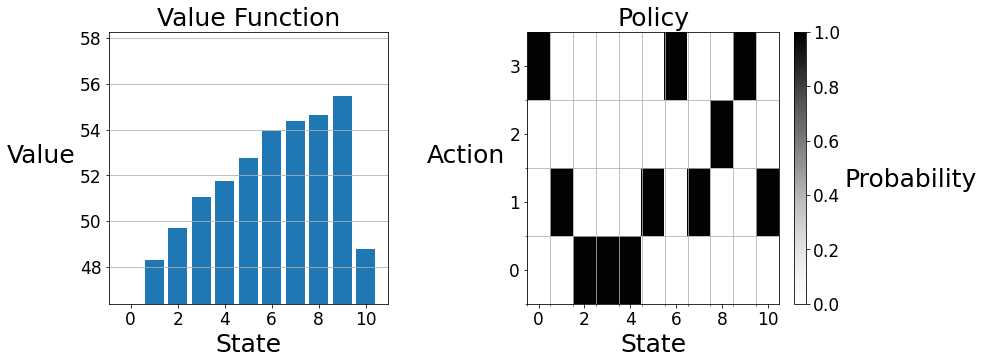

<Figure size 432x288 with 0 Axes>

In [15]:
parking_world.manager.plot(V=v, pi=optimal_policy)